In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['font.family'] = 'Calibri'

import seaborn as sb
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu

import matplotlib.patches as mpatches
from scipy.stats import wilcoxon, ttest_ind
from scipy.stats import pearsonr

from scipy import stats
import seaborn as sns
import matplotlib.colors as mcolors

from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.expand_frame_repr', True)
import warnings
warnings.filterwarnings('ignore')

path = '/home/ripper8/projects/working_data/GRNv3knockouts/analysis'
experiments = ['reg10m2', 'reg2m2']


In [137]:
traits = ['disp_y', 'distance', 'extremities_prop', 'symmetry', 'proportion', 'coverage', 'extensiveness_prop', 'branching_prop', 'brick_prop', 'modules_count',
             'hinge_ratio', 'hinge_prop', 'head_balance']
df_traits = {}
df_categ_traits = {}

for trait in traits:
    print('>>>>>',trait)
    df_traits[trait] = pd.read_csv(f'{path}/knockouts/data/effects_{trait}.csv')
    df_traits[trait]['epistasis_percent'] = df_traits[trait]['positive'] + df_traits[trait]['negative']
    df_traits[trait]['avg_negative']  = df_traits[trait]['avg_negative'] * -1

    df_categ_traits[trait] = pd.read_csv(f'{path}/knockouts/data/effectscateg_{trait}.csv')

   

>>>>> disp_y
>>>>> distance
>>>>> extremities_prop
>>>>> symmetry
>>>>> proportion
>>>>> coverage
>>>>> extensiveness_prop
>>>>> branching_prop
>>>>> brick_prop
>>>>> modules_count
>>>>> hinge_ratio
>>>>> hinge_prop
>>>>> head_balance


In [3]:

keys = ['experiment_name', 'run', 'gen', 'individual_id']

df_complexity = pd.read_csv(f'{path}/complexity/complexity.csv').drop(columns=['geno_size'])
df_complexity_net = pd.read_csv(f'{path}/complexity/complexity_net.csv')
df_complexity_all = pd.merge(df_complexity, df_complexity_net, on=keys, how='inner')


measures = pd.read_csv(f'{path}/basic_plots/all_df.csv')
measures = measures.rename(columns={'generation_index': 'gen', 
                                  'experiment': 'experiment_name'})[keys+['modules_count']]

# df_complexity_all = pd.merge(df_complexity_all, measures, on=keys, how='inner')# this normalization would dilute the changes
# df_complexity_all['complexity_env'] = df_complexity_all['complexity_env'] /df_complexity_all['modules_count'] 

df_complexity_all['interactions_density'] = df_complexity_all['complexity_net'] / df_complexity_all['n_genes']

>>>>> disp_y
>> reg10m2


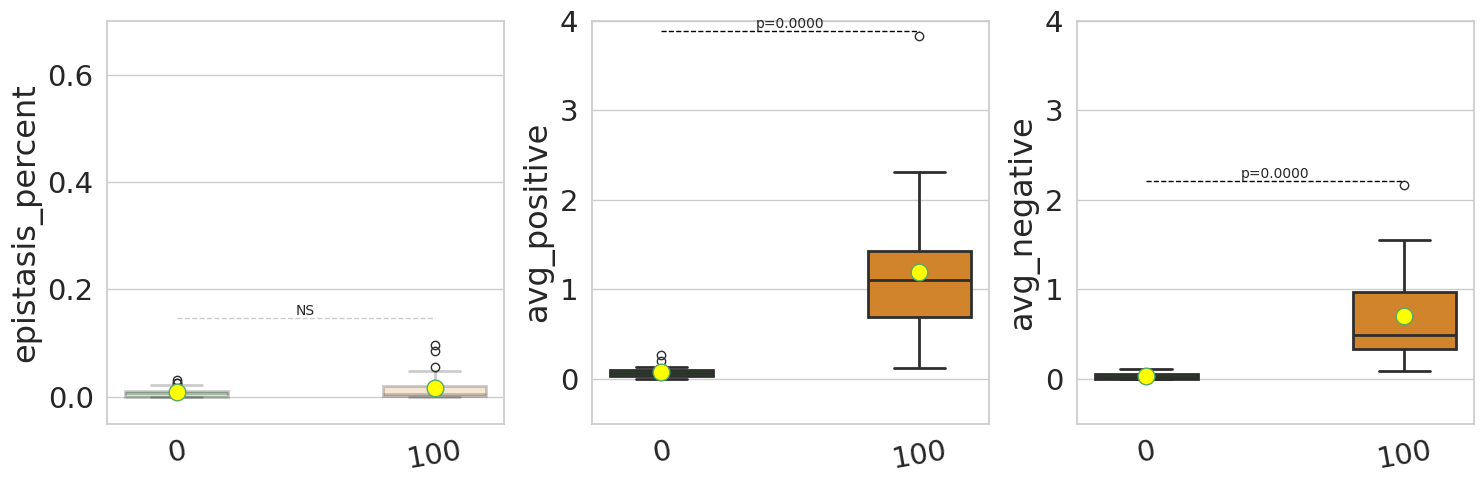

>> reg2m2


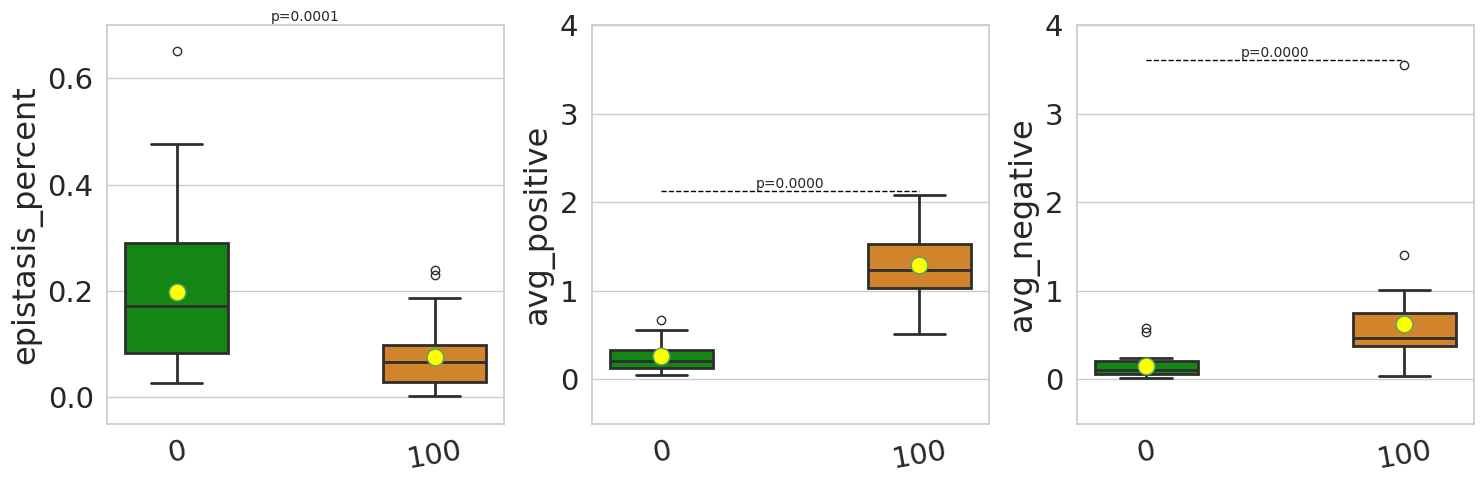

>>>>> distance
>> reg10m2


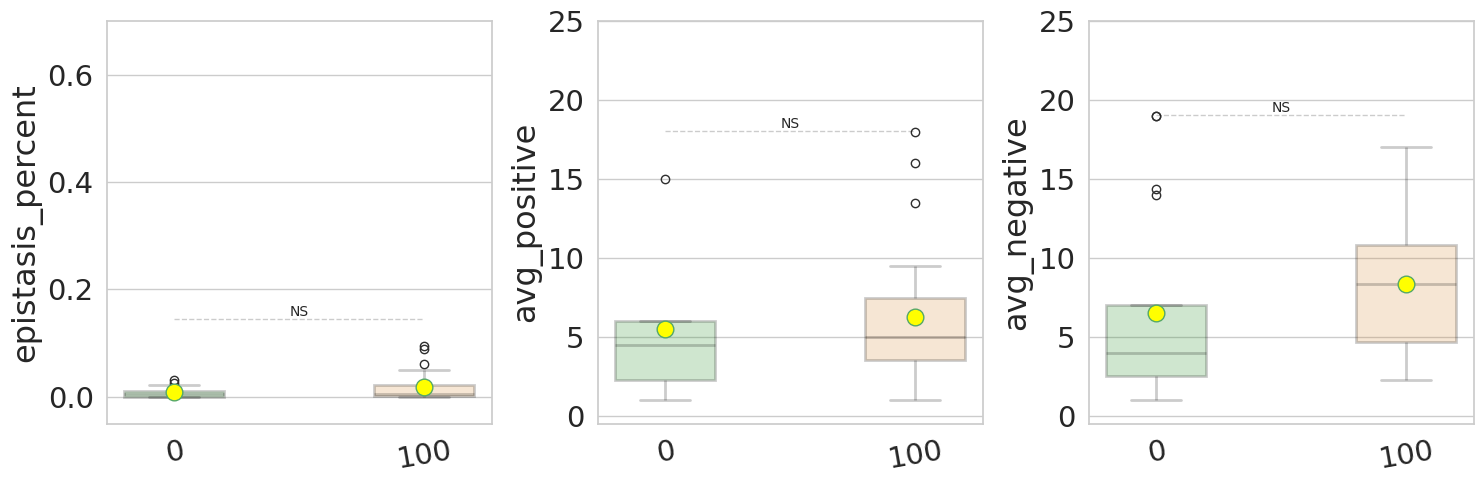

>> reg2m2


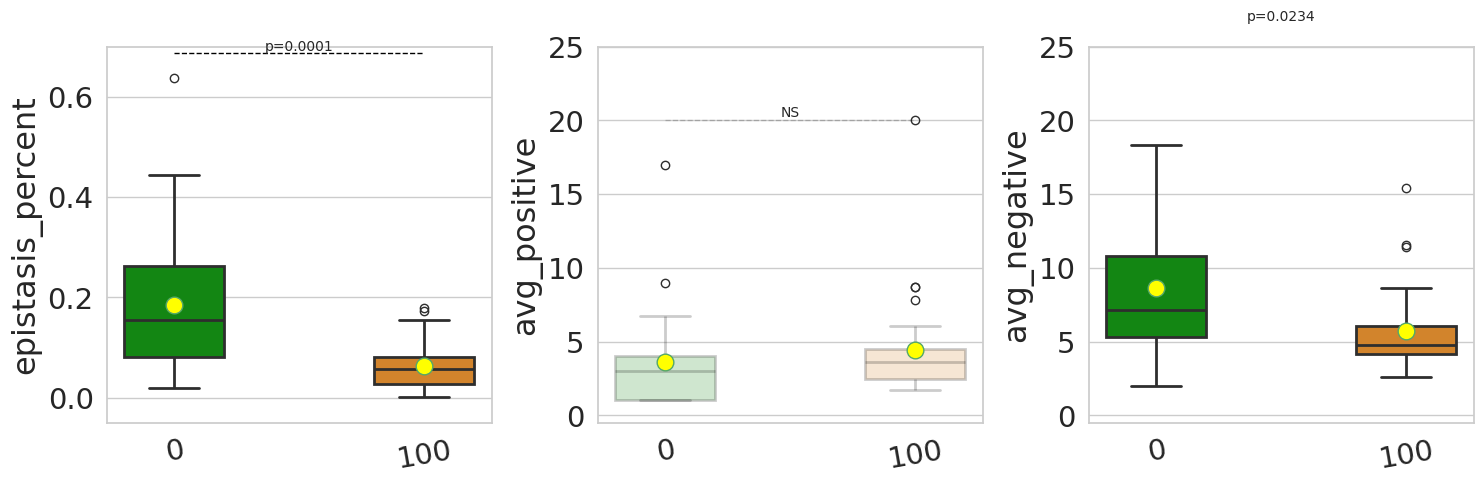

>>>>> proportion
>> reg10m2


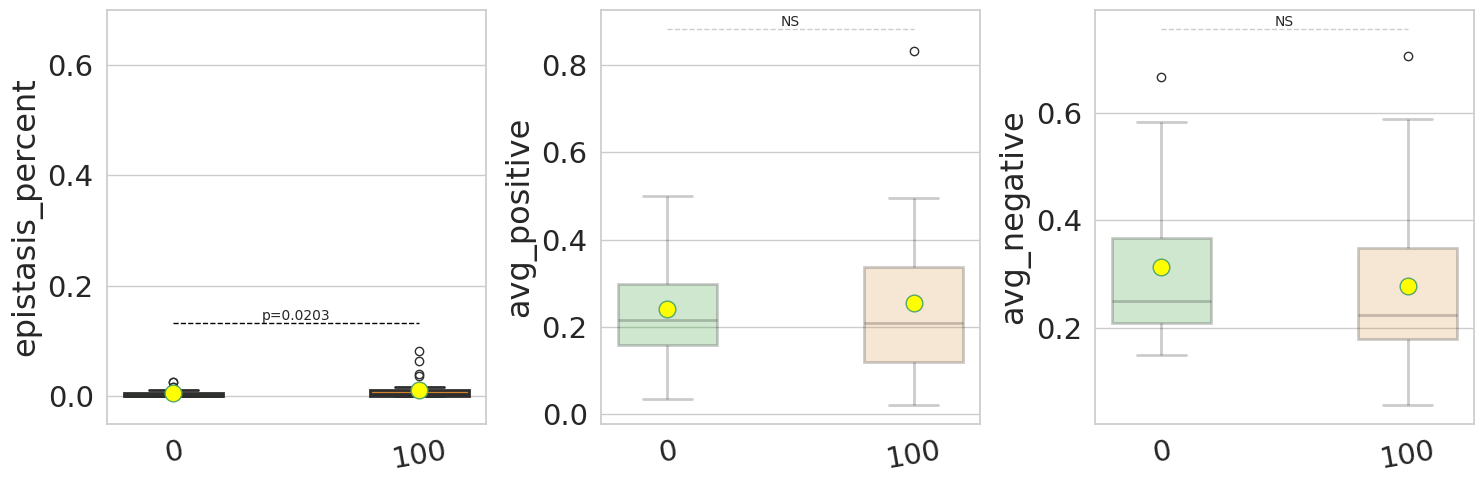

>> reg2m2


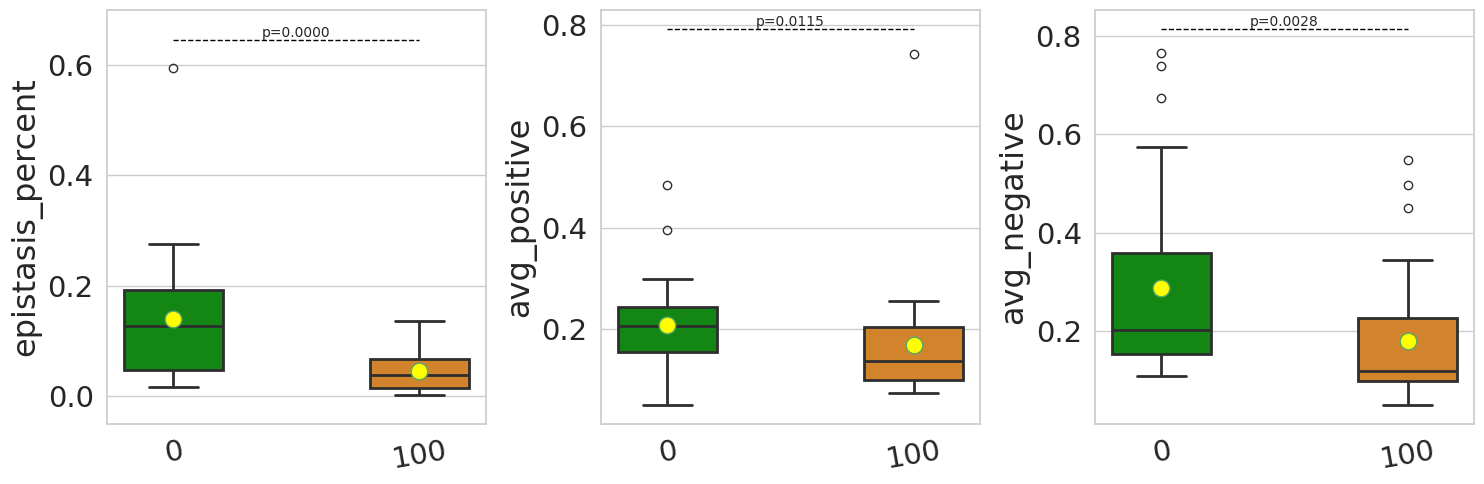

>>>>> head_balance
>> reg10m2


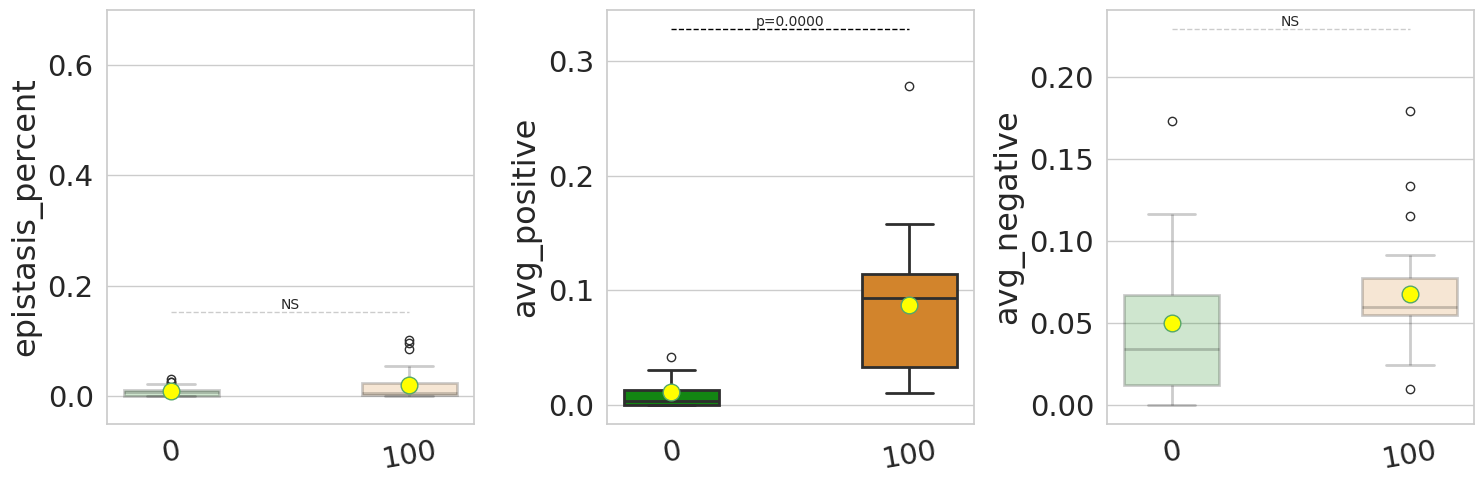

>> reg2m2


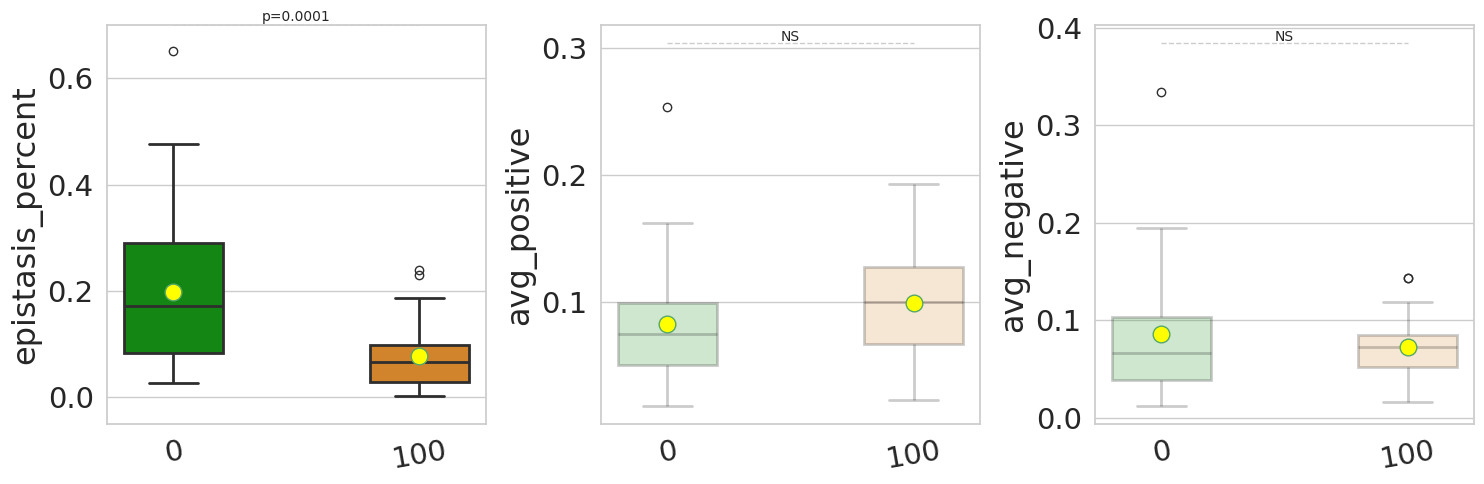

In [197]:


### EPISTASIS CHANGES ###

metrics = ['epistasis_percent',  'avg_positive',  'avg_negative']

clrs = ['#009900',
        '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4],'extremities_prop': [-0.05, 1.1],'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

for trait in traits:
    print('>>>>>',trait)
    df_trait = df_traits[trait].copy(deep=True)
    

    for exp in experiments:
        print('>>',exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
        df_trait_exp = df_trait_exp[ (df_trait_exp['ranking'] == 'best') ] 
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
        sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
        sb.set_style("whitegrid")
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
           # print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")

            sb.boxplot(x='gen', y=f'{metric}', data=filtered_clean,
                       palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                       meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)

            y_max = filtered_clean[f'{metric}'].max() + 0.05  #
            x_positions = [0, 1]  
            ax.plot(x_positions, [y_max, y_max], color='black', linestyle='--', linewidth=1)
            if p_value >= 0.05:
                sig = 'NS'
                alpha = 0.2
                for patch in ax.patches:
                    patch.set_alpha(alpha)
                    patch.set_edgecolor((0.0, 0.0, 0.0, alpha))  # Example RGBA border color
                for line in ax.lines:
                    if line.get_linestyle() == '-' or line.get_linestyle() == '--':
                        line.set_color((0.0, 0.0, 0.0, alpha))  
                 
            else:
                sig = f'p={p_value:.4f}'
            ax.text(x=0.5, y=y_max, s=sig, ha='center', va='bottom', fontsize=10)
            
            if metric in ['epistasis_percent']:
                ax.set_ylim(-0.05, 0.7)

            if metric == 'avg_positive' or metric == 'avg_negative':
                if trait in avg_pos_scale.keys():
                    ax.set_ylim(avg_pos_scale[trait][0], avg_pos_scale[trait][1])
      
            ax.tick_params(axis='x', labelrotation=10)
            
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')
       
        plt.tight_layout()
        plt.show()







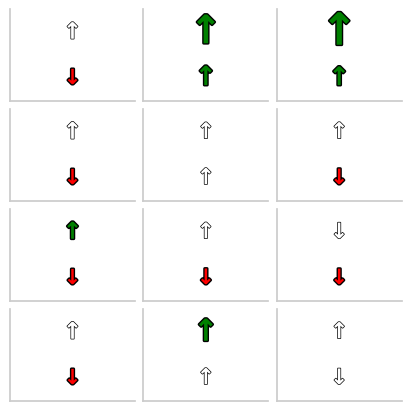

In [215]:


import matplotlib.patheffects as path_effects

traits = ['disp_y', 'distance', 'proportion', 'head_balance']

# Create a figure: compare gens
fig, ax = plt.subplots(len(traits), len(metrics), figsize=(4, 4), constrained_layout=True)

for i, trait in enumerate(traits):
    df_trait = df_traits[trait].copy(deep=True)
    for j, metric in enumerate(metrics):
        for k, exp in enumerate(experiments):
            df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
            df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            # Calculate the averages
            avg_ini_gen = ini_gen.mean()
            avg_end_gen = end_gen.mean()

            # Perform the Mann-Whitney U test
            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')

            # Calculate the ratio of gen 100 to gen 0
            ratio = (avg_end_gen / avg_ini_gen) * 100

            min_old, max_old = 33, 2868
            min_new, max_new = 15, 40

            # Normalize the variable from [6, 2000] to [10, 60]
            arrow_size = ((ratio - min_old) / (max_old - min_old)) * (max_new - min_new) + min_new

            # Determine the vertical position for stacking
            subcell_height = 1.0 / len(experiments)
            y_position = 1.0 - (k + 1) * subcell_height

            if p_value >= 0.05:
                alpha = 1
                border = 1
            else:
                alpha = 1
                border = 2

            display_text = f'{ratio:.0f}%'
            if ratio > 100:
                if p_value >= 0.05:
                    a_color = 'white'
                else:
                    a_color = 'green'
                # Green arrow pointing up, below the text
           #     ax[i, j].text(0.5, y_position + subcell_height / 2, display_text, ha='center', va='center', fontsize=11, color='black')

                ax[i, j].annotate('↑', xy=(0.5, y_position + 0.5 * subcell_height), xytext=(0.5, y_position + 0.5 * subcell_height),
                  textcoords='axes fraction', alpha=alpha, ha='center', va='center', color=a_color, fontsize=arrow_size, fontweight='bold',
                  path_effects=[path_effects.withStroke(linewidth=border, foreground='black')])

            else:
                # Red arrow pointing down, above the text
               # ax[i, j].text(0.5, y_position + subcell_height / 2, display_text, ha='center', va='center', fontsize=11, color='black')
                if p_value >= 0.05:
                    a_color = 'white'
                else:
                    a_color = 'red'
                ax[i, j].annotate('↓', xy=(0.5, y_position + 0.5 * subcell_height), xytext=(0.5, y_position + 0.5 * subcell_height),
                  textcoords='axes fraction', alpha=alpha, ha='center', va='center', color=a_color, fontsize=arrow_size, fontweight='bold',
                  path_effects=[path_effects.withStroke(linewidth=border, foreground='black')])

            # Draw the borders for each metric cell and subcells
            ax[i, j].spines['top'].set_visible(False)
            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['bottom'].set_visible(True)
            ax[i, j].spines['left'].set_visible(True)

            # Draw the borders for the subcells
            ax[i, j].add_patch(plt.Rectangle((0, y_position), 1, subcell_height, fill=False, edgecolor='white', lw=0.5))

        # Set the grid borders
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

# Set row labels for traits
# for i, trait in enumerate(traits):
#     ax[i, 0].set_ylabel(trait, fontsize=8, rotation=90, labelpad=30, ha='right')

plt.show()
fig.savefig(f'{path}/knockouts/epistasis_change_gens.png', dpi=300, bbox_inches='tight')



>>>>> disp_y
>> 0


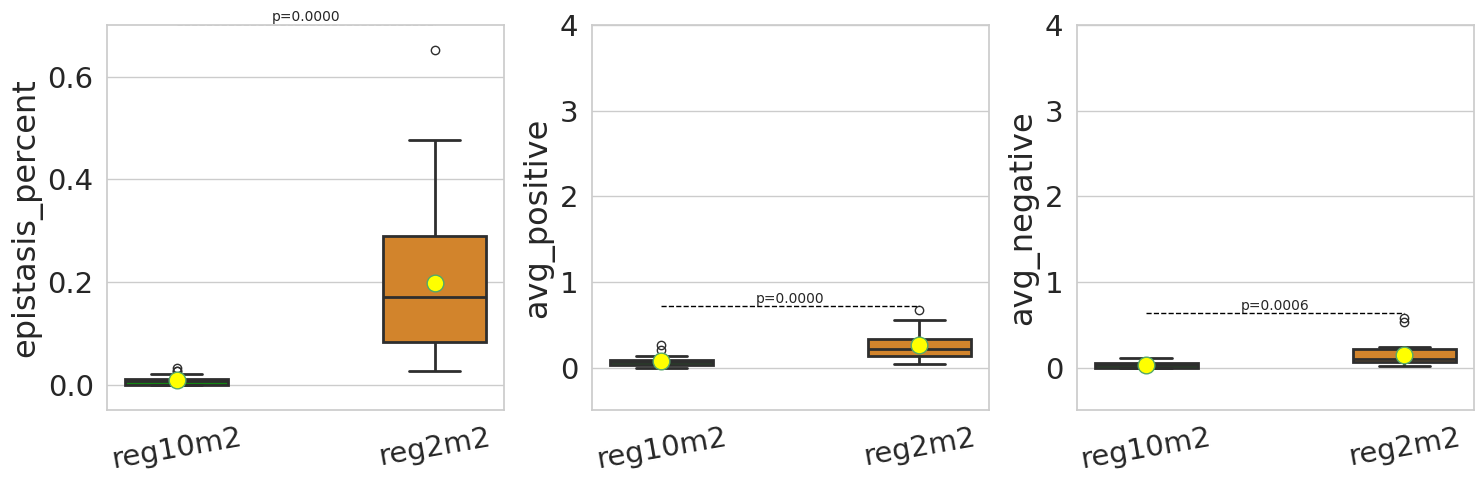

>> 100


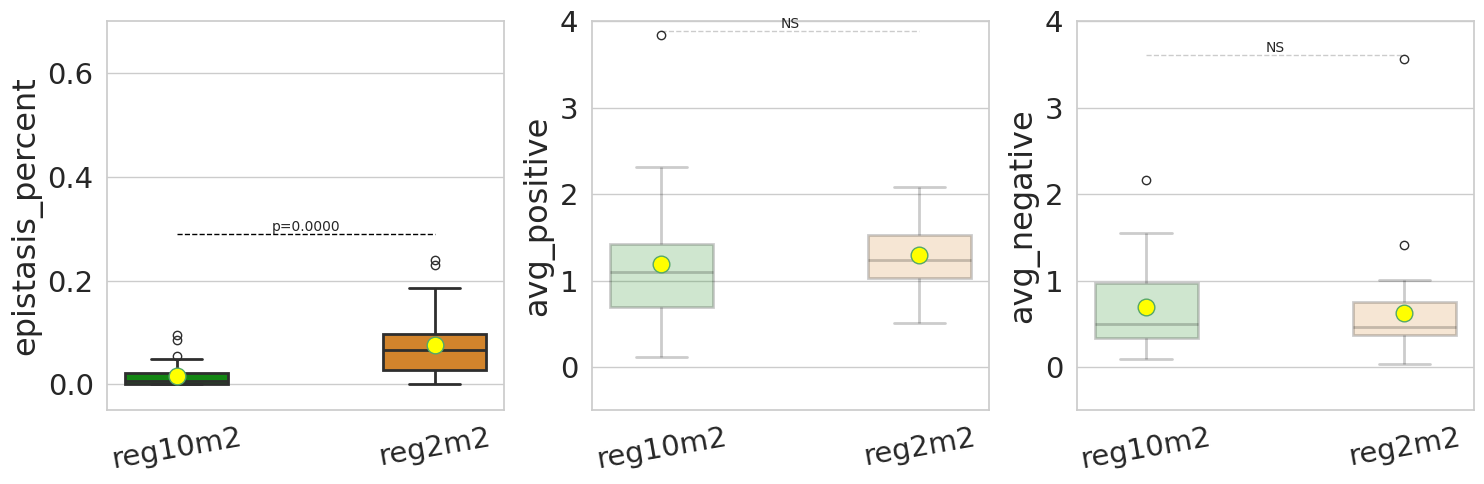

>>>>> distance
>> 0


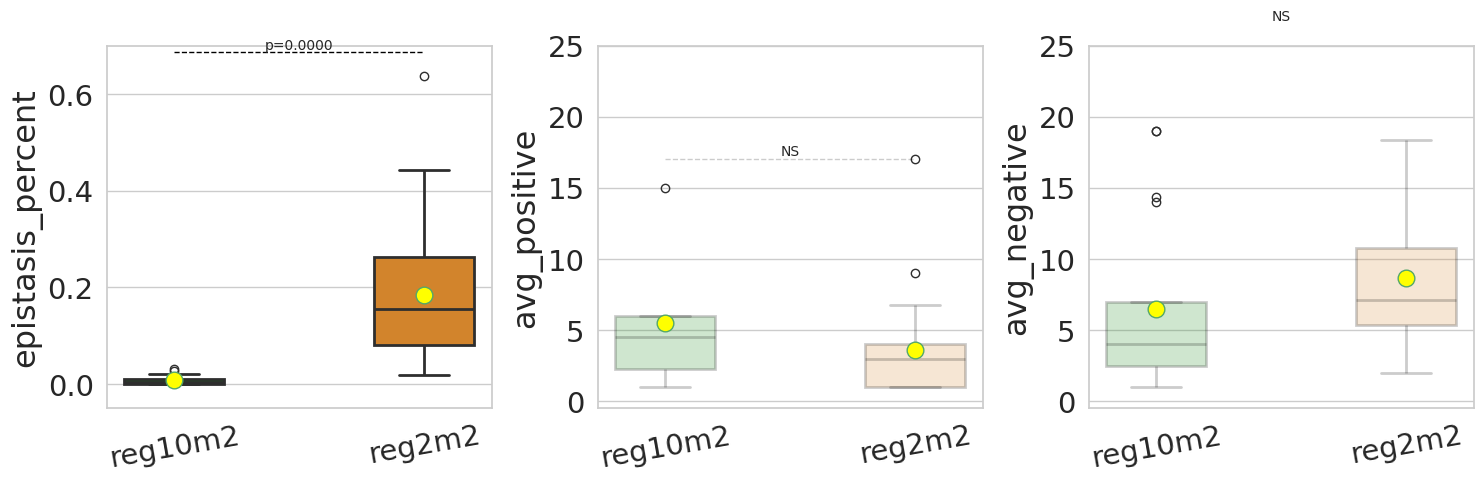

>> 100


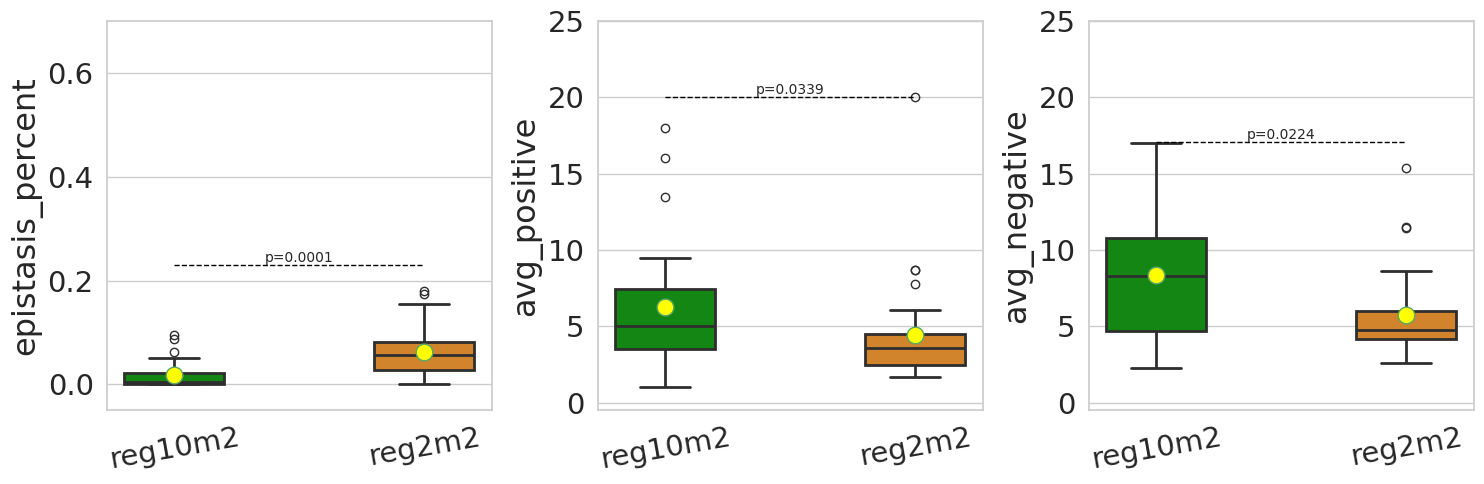

>>>>> proportion
>> 0


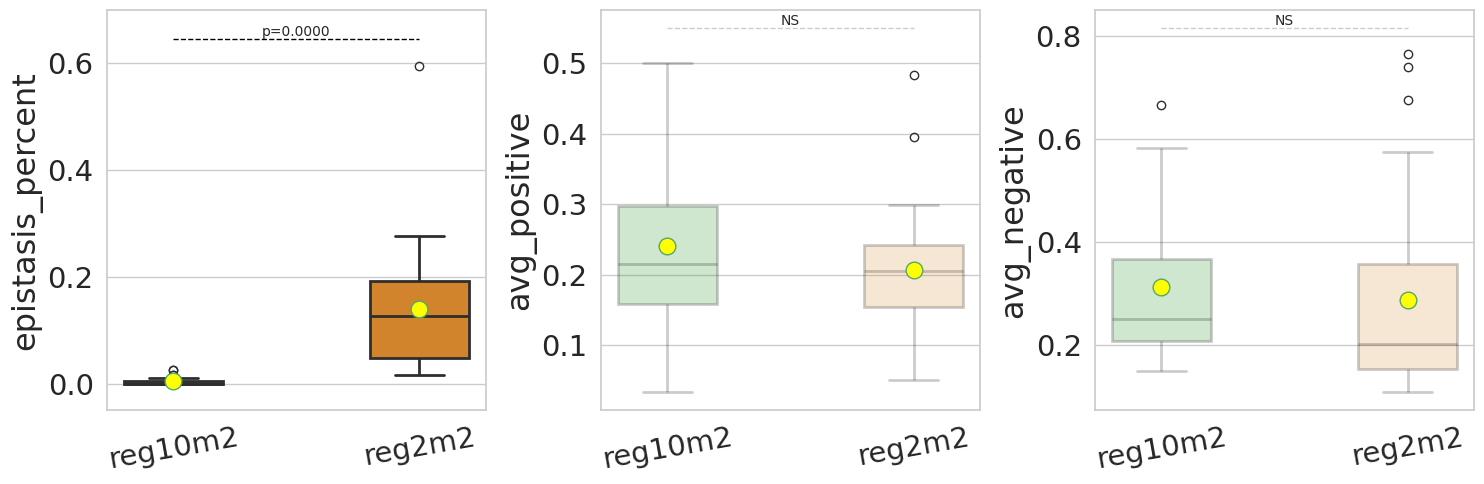

>> 100


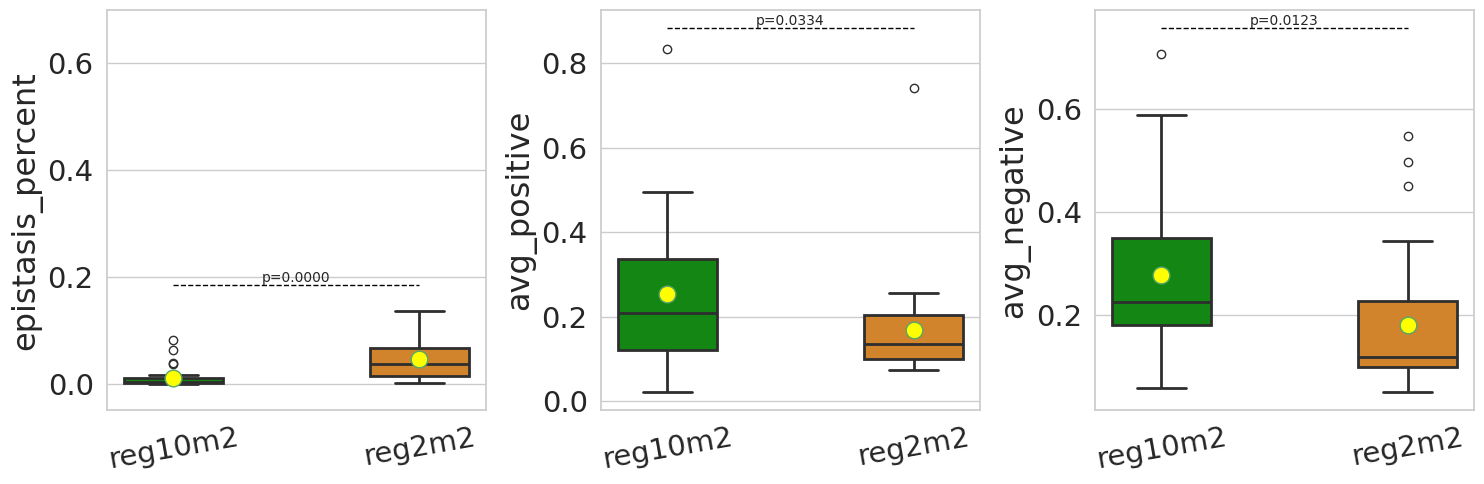

>>>>> head_balance
>> 0


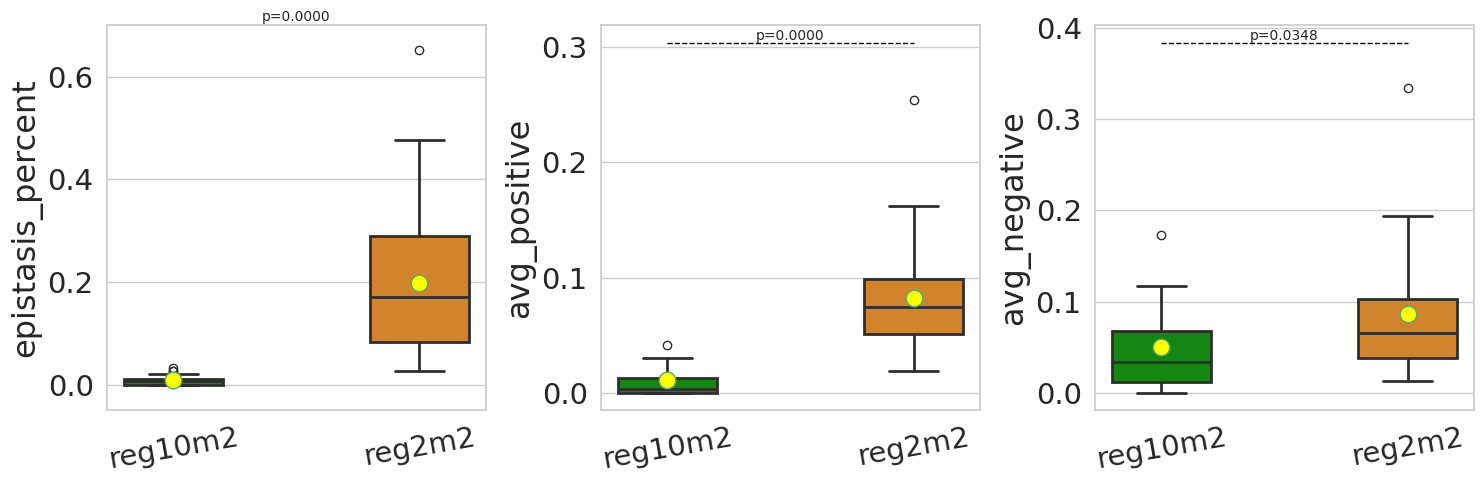

>> 100


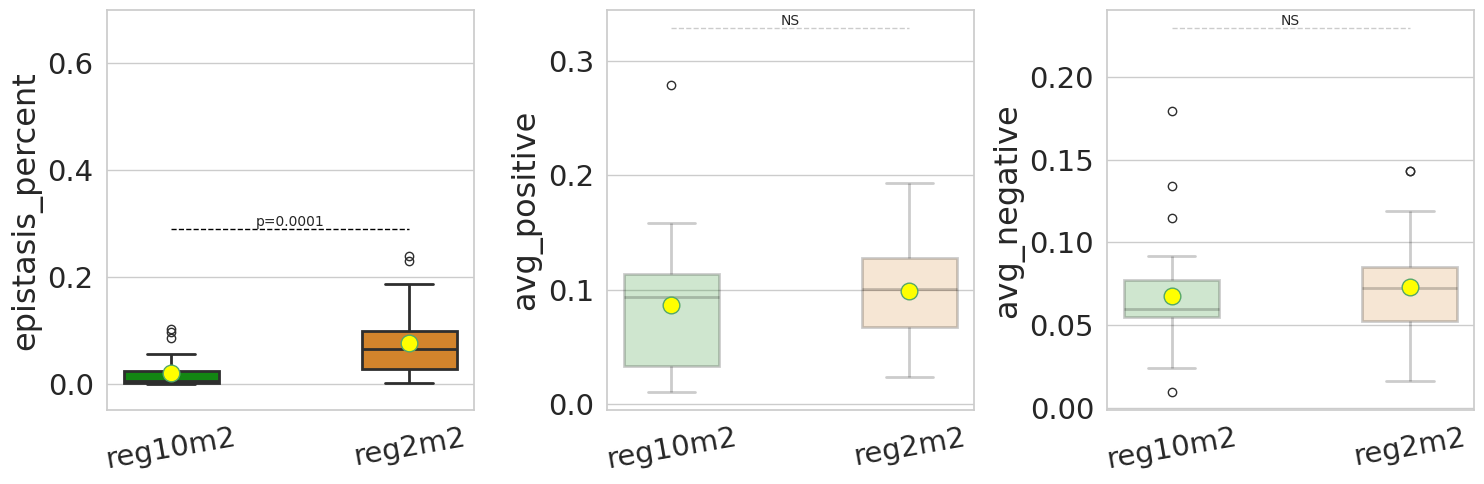

In [202]:


### EPISTASIS CHANGES per exp 
###

metrics = ['epistasis_percent',  'avg_positive',  'avg_negative']

clrs = ['#009900',
        '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4],'extremities_prop': [-0.05, 1.1],'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

for trait in traits:
    print('>>>>>',trait)
    df_trait = df_traits[trait].copy(deep=True)
    
    for gen in [0, 100]:
        print('>>',gen)
        df_trait_exp = df_trait[df_trait['gen'] == gen]
        df_trait_exp = df_trait_exp[ (df_trait_exp['ranking'] == 'best') ] 
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
        sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
        sb.set_style("whitegrid")
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['experiment_name'] == 'reg10m2'][f'{metric}']
            end_gen = filtered_clean[filtered_clean['experiment_name'] == 'reg2m2'][f'{metric}']
     
            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
           # print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")

            sb.boxplot(x='experiment_name', y=f'{metric}', data=filtered_clean,
                       palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                       meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)

            y_max = filtered_clean[f'{metric}'].max() + 0.05  #
            x_positions = [0, 1]  
            ax.plot(x_positions, [y_max, y_max], color='black', linestyle='--', linewidth=1)
            if p_value >= 0.05:
                sig = 'NS'
                alpha = 0.2
                for patch in ax.patches:
                    patch.set_alpha(alpha)
                    patch.set_edgecolor((0.0, 0.0, 0.0, alpha))  # Example RGBA border color
                for line in ax.lines:
                    if line.get_linestyle() == '-' or line.get_linestyle() == '--':
                        line.set_color((0.0, 0.0, 0.0, alpha))  
                 
            else:
                sig = f'p={p_value:.4f}'
            ax.text(x=0.5, y=y_max, s=sig, ha='center', va='bottom', fontsize=10)
            
            if metric in ['epistasis_percent']:
                ax.set_ylim(-0.05, 0.7)

            if metric == 'avg_positive' or metric == 'avg_negative':
                if trait in avg_pos_scale.keys():
                    ax.set_ylim(avg_pos_scale[trait][0], avg_pos_scale[trait][1])
      
            ax.tick_params(axis='x', labelrotation=10)
            
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')
       
        plt.tight_layout()
        plt.show()







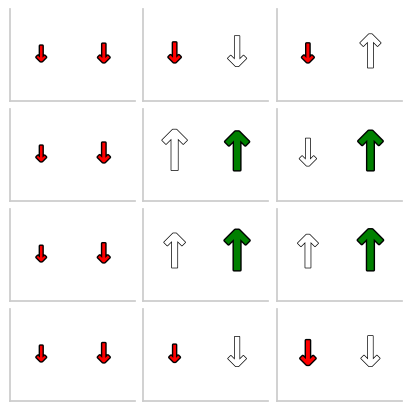

In [216]:

# Create a figure : compare exps
fig, ax = plt.subplots(len(traits), len(metrics), figsize=(4, 4), constrained_layout=True)

for i, trait in enumerate(traits):
    df_trait = df_traits[trait].copy(deep=True)
    for j, metric in enumerate(metrics):
        for k, gen in enumerate([0, 100]):
            df_trait_exp = df_trait[df_trait['gen'] == gen]
            df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            exp1 = filtered_clean[filtered_clean['experiment_name'] == 'reg2m2'][f'{metric}']
            exp2 = filtered_clean[filtered_clean['experiment_name'] == 'reg10m2'][f'{metric}']

            # Calculate the averages
            avg_exp1 = exp1.mean()
            avg_exp2 = exp2.mean()

            # Perform the Mann-Whitney U test
            _, p_value = mannwhitneyu(exp1, exp2, alternative='two-sided')

            # Calculate the ratio of gen 100 to gen 0
            ratio = (avg_exp2 / avg_exp1) * 100

           # print(trait, metric, gen, round(avg_ini_gen,4), round(avg_end_gen,4  ), round(ratio,2))

            # Determine the subcell width and x-position for horizontal stacking
            subcell_width = 1.0 / len(experiments)
            x_position = k * subcell_width

            min_old, max_old = 3, 154
            min_new, max_new = 15, 40
            
            # Normalize the variable from [6, 2000] to [10, 60]
            arrow_zize = ((ratio- min_old) / (max_old - min_old)) * (max_new - min_new) + min_new
            
            if p_value >= 0.05:
                alpha = 1
                border = 1
            else:
                alpha = 1
                border = 2

            display_text = f'{ratio:.0f}%'
            if ratio > 100:
                if p_value >= 0.05:
                    a_color = 'white'
                else:
                    a_color = 'green'

                # Green arrow pointing up, below the text
            #    ax[i, j].text(x_position + subcell_width / 2, 0.65, display_text, ha='center', va='center', fontsize=10, color='black')
                # ax[i, j].annotate('↑', xy=(x_position + subcell_width / 2, 0.35), xytext=(x_position + subcell_width / 2, 0.35),
                #                   textcoords='axes fraction', alpha=alpha, ha='center', va='center', color='green', fontsize=arrow_zize, fontweight='bold',
                #                    path_effects=[path_effects.withStroke(linewidth=border, foreground='black')])
                ax[i, j].annotate('↑', xy=(x_position + subcell_width / 2, 0.5), xytext=(x_position + subcell_width / 2, 0.5),
                  textcoords='axes fraction', alpha=alpha, ha='center', va='center', color=a_color, fontsize=arrow_zize, fontweight='bold',
                   path_effects=[path_effects.withStroke(linewidth=border, foreground='black')])

            else:
                if p_value >= 0.05:
                    a_color = 'white'
                else:
                    a_color = 'red'
                # Red arrow pointing down, above the text
              # ax[i, j].text(x_position + subcell_width / 2, 0.35, display_text, ha='center', va='center', fontsize=10, color='black')
                # ax[i, j].annotate('↓', xy=(x_position + subcell_width / 2, 0.35), xytext=(x_position + subcell_width / 2, 0.35),
                #                   textcoords='axes fraction', alpha=alpha, ha='center', va='center', color='red', fontsize=arrow_zize, fontweight='bold',
                #                    path_effects=[path_effects.withStroke(linewidth=border, foreground='black')])
                ax[i, j].annotate('↓', xy=(x_position + subcell_width / 2, 0.5), xytext=(x_position + subcell_width / 2, 0.5),
                  textcoords='axes fraction', alpha=alpha, ha='center', va='center', color=a_color, fontsize=arrow_zize, fontweight='bold',
                   path_effects=[path_effects.withStroke(linewidth=border, foreground='black')])

            # Draw the borders for each metric cell and subcells
            ax[i, j].spines['top'].set_visible(False)
            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['bottom'].set_visible(True)
            ax[i, j].spines['left'].set_visible(True)        

            # Draw the borders for the subcells
            ax[i, j].add_patch(plt.Rectangle((x_position, 0), subcell_width, 1, fill=False, edgecolor='white', lw=0.5))

        # Set the grid borders
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

# Set row labels for traits
# for i, trait in enumerate(traits):
#     ax[i, 0].set_ylabel(trait, fontsize=8, rotation=90, labelpad=30, ha='right')

plt.show()
fig.savefig(f'{path}/knockouts/epistasis_change_exps.png', dpi=300, bbox_inches='tight')



>> reg10m2


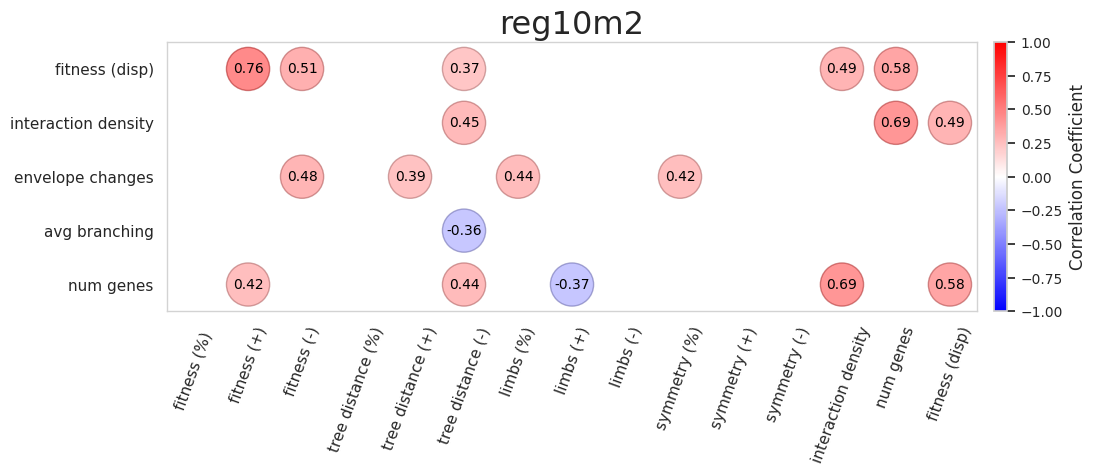

>> reg2m2


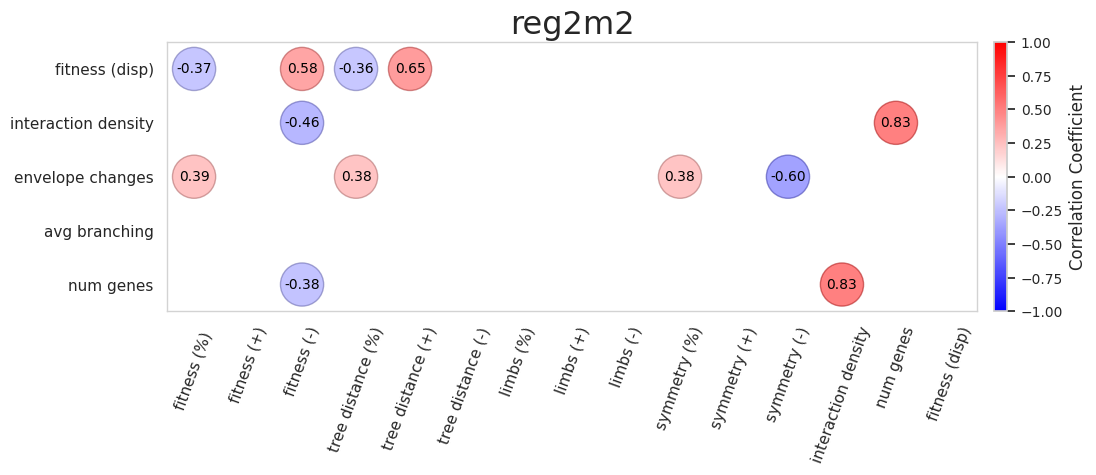

In [125]:
### CORRELATIONS: EPISTASIS VS PHENOCOMPLEXITY


df_complexity_end = df_complexity_all[(df_complexity_all['gen'] == 100)]

metrics1 = ['n_genes', 'complexity_branch', 'complexity_env', 'interactions_density', 'disp_y']
additional_columns = ['interactions_density', 'n_genes', 'disp_y'] 
metrics2 = []

metrics1_adjusted = ['num genes', 'avg branching', 'envelope changes', 'interaction density', 'fitness (disp)']
metrics2_adjusted = ['fitness (%) ', 'fitness (+)', 'fitness (-)', 'tree distance (%)', 
                     'tree distance (+)', 'tree distance (-)', 'limbs (%)', 
                     'limbs (+)', 'limbs (-)', 'symmetry (%)', 
                     'symmetry (+)', 'symmetry (-)']
additional_columns_adjusted = ['interaction density', 'num genes', 'fitness (disp)']


for idx,trait in enumerate(traits):
    df_trait = df_traits[trait].copy(deep=True) 
    df_trait = df_trait.drop(columns=['Unnamed: 0'])

    corr_df = pd.merge(df_complexity_end, df_trait, on=keys, how='inner')
    corr_df = corr_df.rename(columns={'epistasis_percent': 'epistasis_percent_'+trait, 
                                      'avg_positive': 'avg_positive_'+trait, 
                                      'avg_negative': 'avg_negative_'+trait})
    metrics2.append('epistasis_percent_'+trait)
    metrics2.append('avg_positive_'+trait)
    metrics2.append('avg_negative_'+trait)
   
    obsolete_vars = ['symmetry', 'extremities_prop' ,'neutral', 'positive', 'negative', 'epistasis']
    redudant_vars = [ 'ranking', 'disp_y', 'geno_size', 'n_genes' ,'complexity_env',
                     'complexity_branch', 'complexity_net', 'interactions_density']

    if idx == 0:
        corr_df_all = corr_df.drop(columns=obsolete_vars)
    else:
        corr_df = corr_df.drop(columns=obsolete_vars+redudant_vars)
        corr_df_all = pd.merge(corr_df_all, corr_df, on=keys, how='inner')



for idx_experiment, exp in enumerate(experiments):
    print('>>', exp)
    df_complexity_end_exp = corr_df_all[(corr_df_all['experiment_name'] == exp)]
    df_complexity_end_exp = df_complexity_end_exp[ (df_complexity_end_exp['ranking'] == 'best') ] 
    df_complexity_end_exp[df_complexity_end_exp.select_dtypes(include=['number']).columns] = \
                df_complexity_end_exp.select_dtypes(include=['number']).fillna(0)

    def darken_color(color, factor=0.7):
        r, g, b, a = mcolors.to_rgba(color)
        return mcolors.to_hex((r * factor, g * factor, b * factor, a))
    
    # Function to calculate correlation and p-values
    def calculate_corr_and_pvalues(df):
        corr_matrix = df.corr()
        p_values = pd.DataFrame(np.zeros_like(corr_matrix, dtype=float), index=corr_matrix.index, columns=corr_matrix.columns)
        
        for i in range(len(corr_matrix.columns)):
            for j in range(len(corr_matrix.columns)):
                if i != j:
                    corr, p_value = stats.pearsonr(df.iloc[:, i], df.iloc[:, j])
                    p_values.iloc[i, j] = p_value
                    if p_value < 0.05:
                        pass
                        #print(corr_matrix.columns[i], corr_matrix.columns[j], corr, p_value)
                else:
                    p_values.iloc[i, j] = np.nan  # No p-value for self-correlation
    
        return corr_matrix, p_values
    
   
    # Compute correlations and p-values
    corr_matrix, p_values = calculate_corr_and_pvalues(df_complexity_end_exp[metrics1 + metrics2])

    original_names = metrics1 + metrics2 + additional_columns
    adjusted_names = metrics1_adjusted + metrics2_adjusted + additional_columns_adjusted
    rename_mapping = {original: adjusted for original, adjusted in zip(original_names, adjusted_names)}
    corr_matrix = corr_matrix.rename(columns=rename_mapping, index=rename_mapping)
    p_values = p_values.rename(columns=rename_mapping, index=rename_mapping)
    
    #display(corr_matrix)
    
    # Select the relevant portion of the correlation matrix
    corr_matrix = corr_matrix.loc[metrics1_adjusted, metrics2_adjusted + additional_columns_adjusted]
    p_values = p_values.loc[metrics1_adjusted, metrics2_adjusted + additional_columns_adjusted]
    
    # Create a mask for significant correlations
    significance_mask = p_values < 0.05
    
    # Create a color map from blue to red
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'blue_red',
        ['blue', 'white', 'red'],
        N=256
    )
    
    # Plotting
    plt.figure(figsize=(11, 3.5))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('#D3D3D3')   # Set the color for all spines
        spine.set_linewidth(1) 
    
    # Draw the circles for significant correlations
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            if significance_mask.iloc[i, j]:
                circle_color = cmap((corr_matrix.iloc[i, j] + 1) / 2)  # Normalize correlation to [0, 1]
                border_color = darken_color(circle_color, factor=0.7)  # Darken the fill color for border
            
                circle = plt.Circle((j, i), 0.4, color=circle_color, alpha=0.6, ec=border_color, linewidth=1, zorder=10)
                ax.add_patch(circle)
                plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', color='black', 
                         ha='center', va='center', fontsize=10, zorder=20)
    
    # Set the labels and limits
    plt.xticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=70, fontsize=11)
    plt.yticks(ticks=np.arange(len(corr_matrix.index)), labels=corr_matrix.index, fontsize=11)
    plt.xlim(-0.5, len(corr_matrix.columns) - 0.5)
    plt.ylim(len(corr_matrix.index) - 0.5, -0.5)

    plt.title(exp)
    plt.grid(False)
    plt.gca().invert_yaxis()

    # Create and add color bar
    norm = mcolors.Normalize(vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('Correlation Coefficient', fontsize=12)
    plt.savefig(f'{path}/knockouts/corr_{exp}.png', dpi=300, bbox_inches='tight')
    plt.show()



 >>>>> metrics_dist disp_y

 >>>>> metric_order avg_positive_disp_y

 -- reg10m2
Average first : 1.1605089848590682
Average second : 1.9608992196541901
  p-value: 0.0001


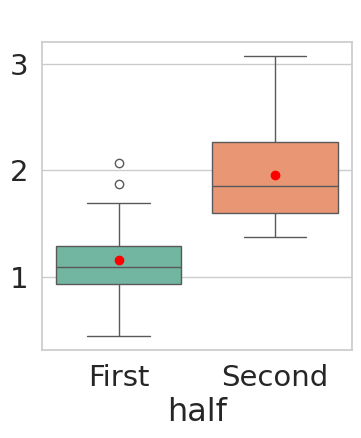


 -- reg2m2
Average first : 2.058426174079068
Average second : 2.2239852293161664
  p-value: 0.3404


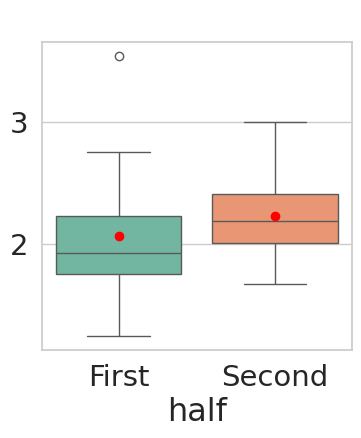


 >>>>> metric_order avg_negative_disp_y

 -- reg10m2
Average first : 1.2530223894079737
Average second : 1.8683858151052846
  p-value: 0.0044


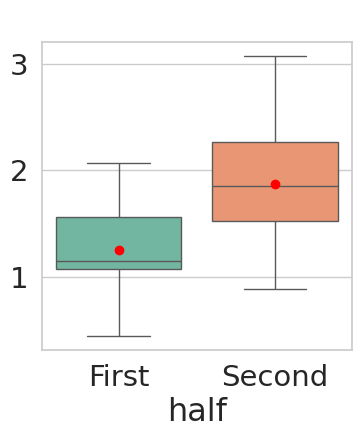


 -- reg2m2
Average first : 2.04878273292755
Average second : 2.2336286704676853
  p-value: 0.2861


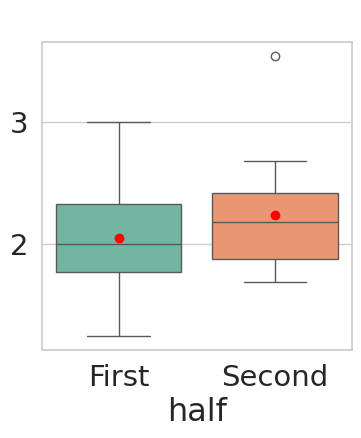


 >>>>> metric_order epistasis_percent_disp_y

 -- reg10m2
Average first : 1.541658495191103
Average second : 1.5797497093221557
  p-value: 0.8698


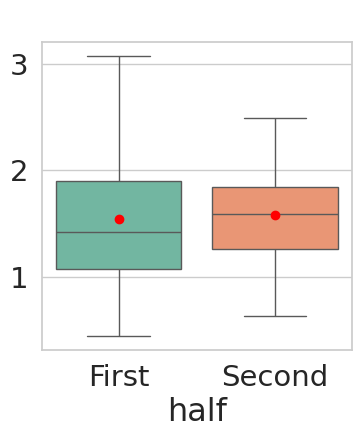


 -- reg2m2
Average first : 2.2818502112757404
Average second : 2.000561192119494
  p-value: 0.0997


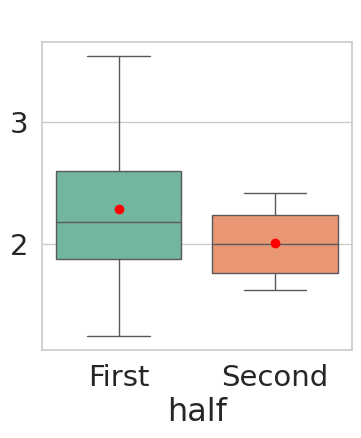


 >>>>> metrics_dist complexity_env

 >>>>> metric_order avg_positive_disp_y

 -- reg10m2
Average first : 13.866666666666667
Average second : 16.4
  p-value: 0.304


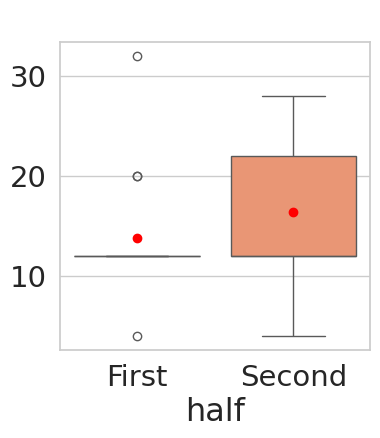


 -- reg2m2
Average first : 14.533333333333333
Average second : 18.133333333333333
  p-value: 0.0592


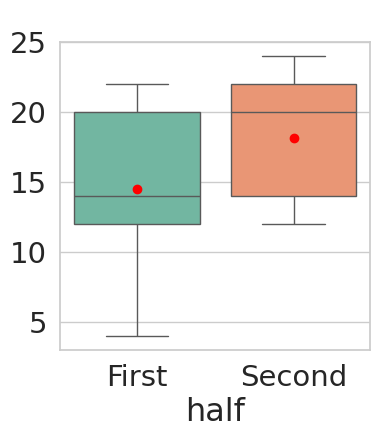


 >>>>> metric_order avg_negative_disp_y

 -- reg10m2
Average first : 13.466666666666667
Average second : 16.8
  p-value: 0.1731


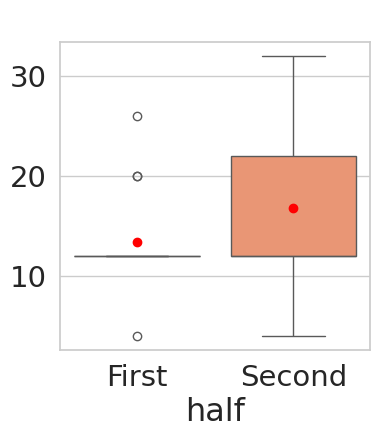


 -- reg2m2
Average first : 18.133333333333333
Average second : 14.533333333333333
  p-value: 0.0592


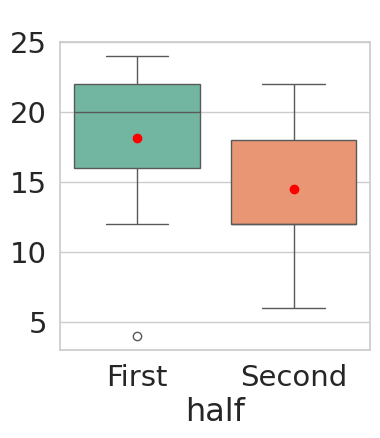


 >>>>> metric_order epistasis_percent_disp_y

 -- reg10m2
Average first : 13.866666666666667
Average second : 16.4
  p-value: 0.304


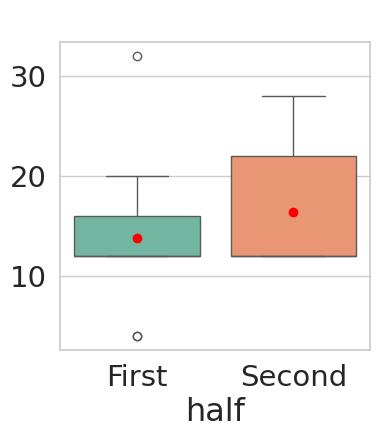


 -- reg2m2
Average first : 15.333333333333334
Average second : 17.333333333333332
  p-value: 0.3054


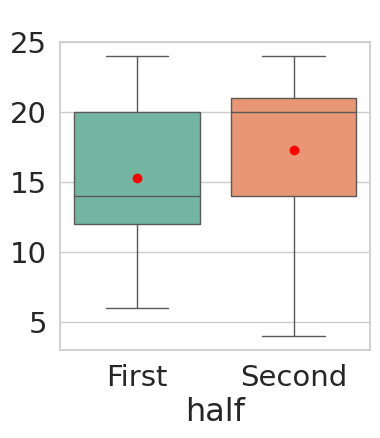

In [131]:

### epistais vs fit


metrics_dist = ['disp_y']
metrics_order = ['avg_positive_disp_y', 'avg_negative_disp_y','epistasis_percent_disp_y' ]

for metric_dist in metrics_dist:
    print(f'\n >>>>> metrics_dist',metric_dist)
    for metric_order in metrics_order:
        print(f'\n   >>> metric_order',metric_order)
        for exp in experiments:
            print('\n --',exp)
            df_comp_g = corr_df_all[ (corr_df_all['experiment_name'] == exp) ] 
            df_comp_g[df_comp_g.select_dtypes(include=['number']).columns] = \
                    df_comp_g.select_dtypes(include=['number']).fillna(0)
            df_comp_g = df_comp_g[ (df_comp_g['ranking'] == 'best') ] 
            df_sorted = df_comp_g.sort_values(by=metric_order).reset_index(drop=True)
                   
    
            midpoint = len(df_sorted) // 2
            first_half = df_sorted.iloc[:midpoint]
            second_half = df_sorted.iloc[midpoint:]
            
            # Calculate and display the averages for 'b' in each half
            avg_first_half = first_half[metric_dist].mean()
            avg_second_half = second_half[metric_dist].mean()
     
            print(f"Average first : {avg_first_half}")
            print(f"Average second : {avg_second_half}")
            
            t_stat, p_value = ttest_ind(first_half[metric_dist], second_half[metric_dist], equal_var=True)
    
            #_, p_value = mannwhitneyu(first_half[metric_dist], second_half[metric_dist], alternative='two-sided')
            print(f"  p-value: {round(p_value, 4)}")
            
            # Add a new column to each half to indicate "First Half" or "Second Half"
            first_half['half'] = 'First'
            second_half['half'] = 'Second'
            
            #  Concatenate the two halves back into a single DataFrame
            df_concat = pd.concat([first_half, second_half], ignore_index=True)
            
            # Plot variable 'disp_y' for each half using box plots
            plt.figure(figsize=(4, 4))
            sb.boxplot(x='half', y=metric_dist, data=df_concat, palette="Set2")
            
            plt.scatter(x=[0], y=[avg_first_half], color='red', label='Mean', zorder=5)
            plt.scatter(x=[1], y=[avg_second_half], color='red', zorder=5)
            
            plt.title(' ')
            plt.ylabel('' )
            plt.show() 


>>>>> disp_y
>> reg10m2


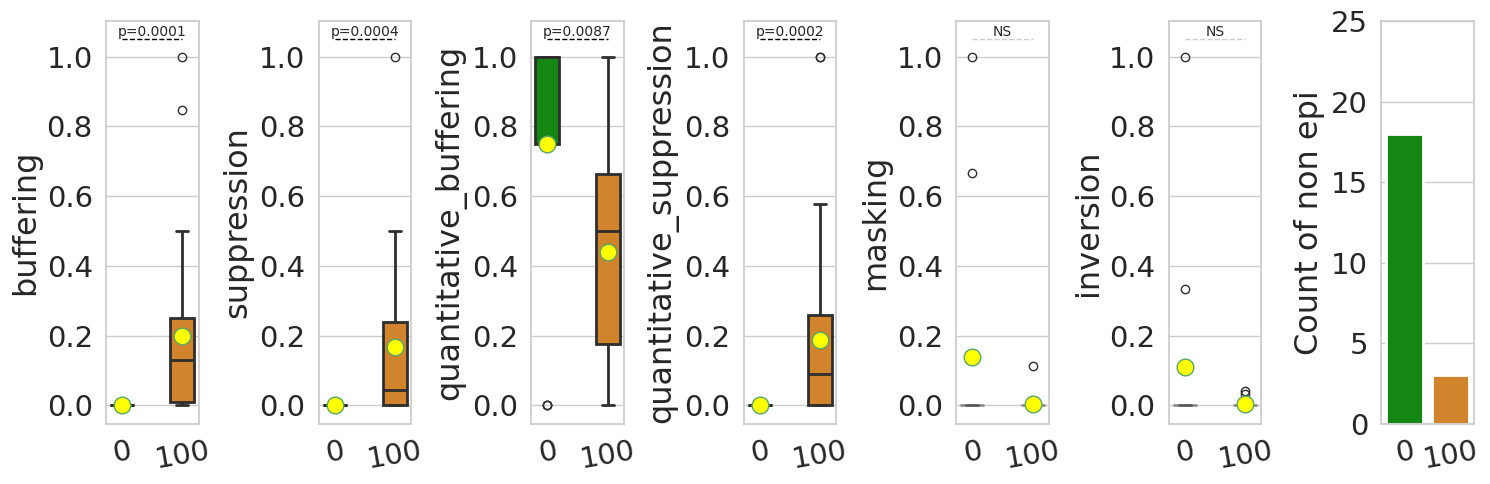

>> reg2m2


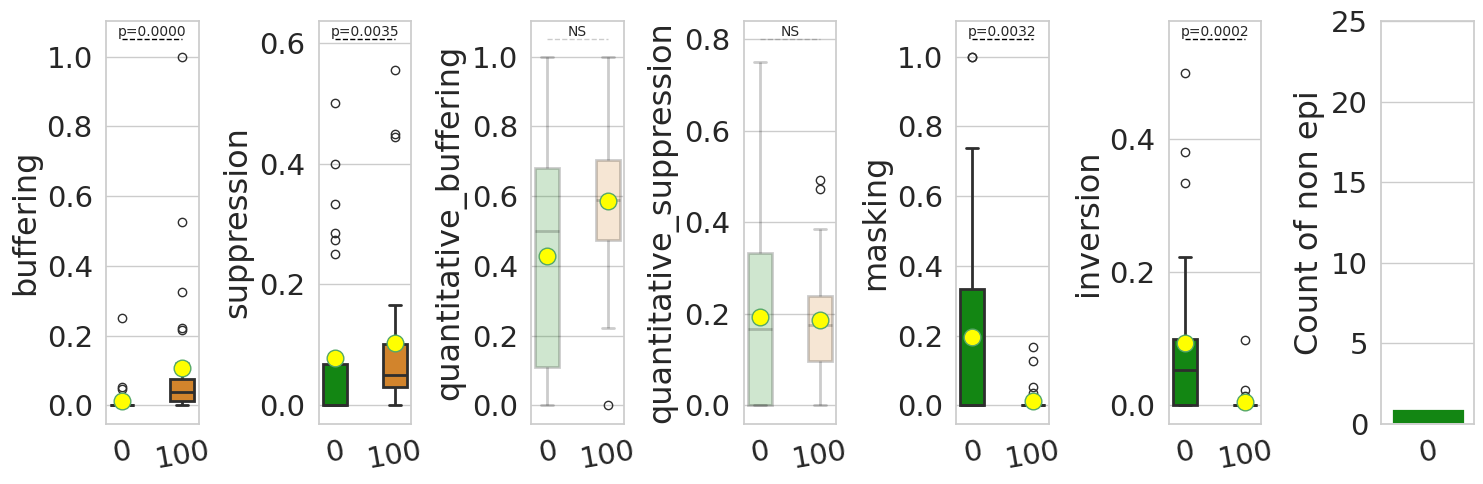

>>>>> distance
>> reg10m2


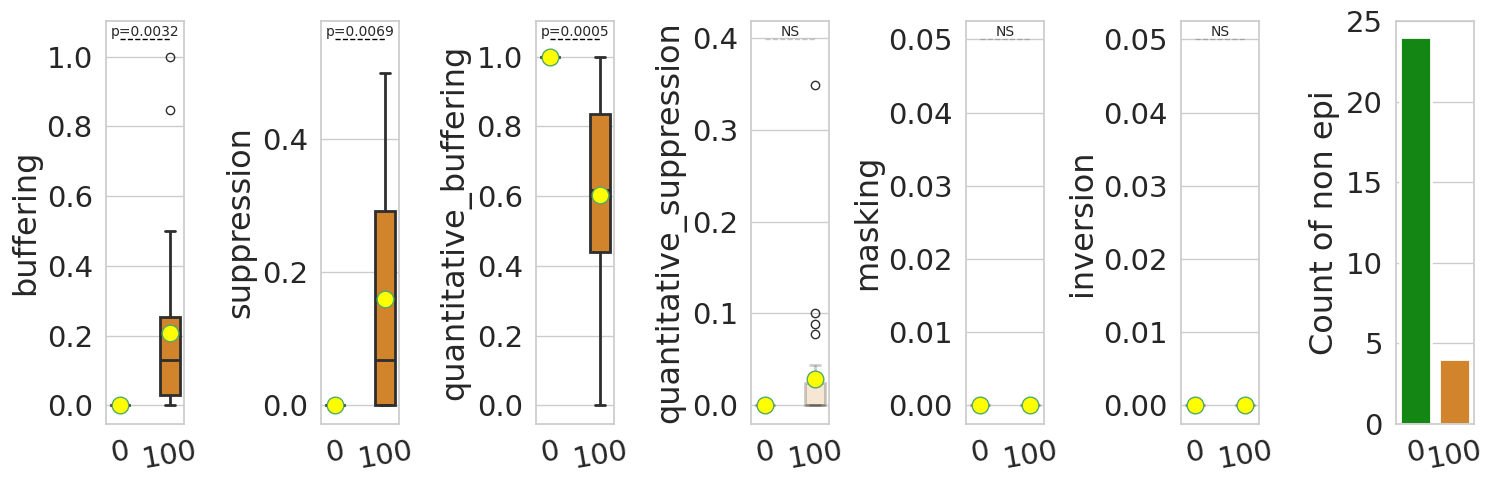

>> reg2m2


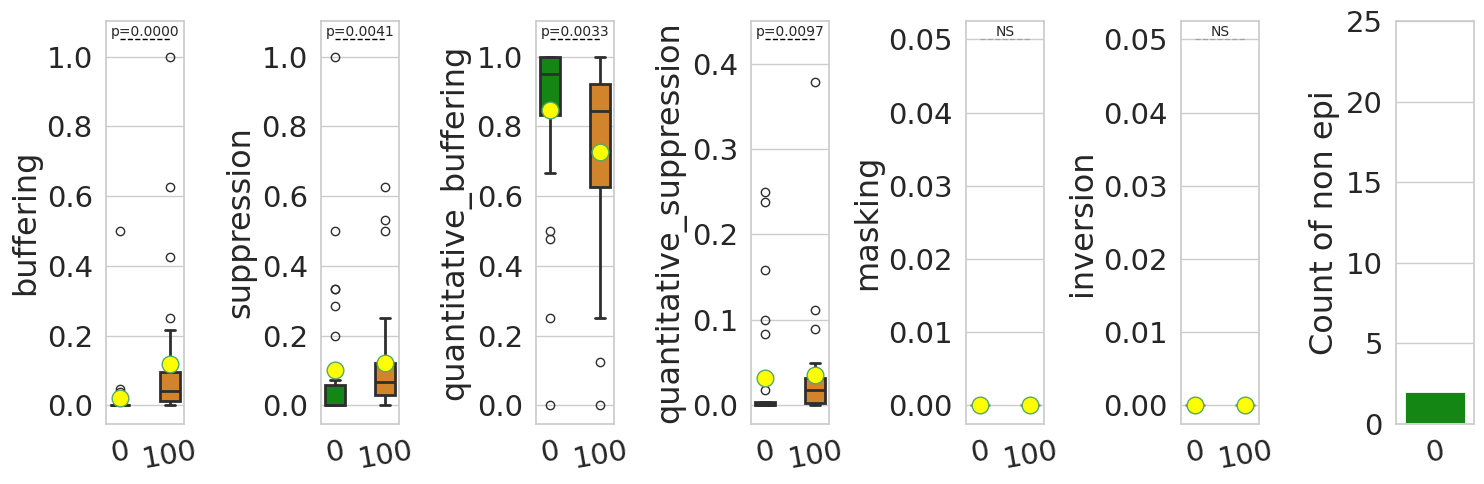

>>>>> proportion
>> reg10m2


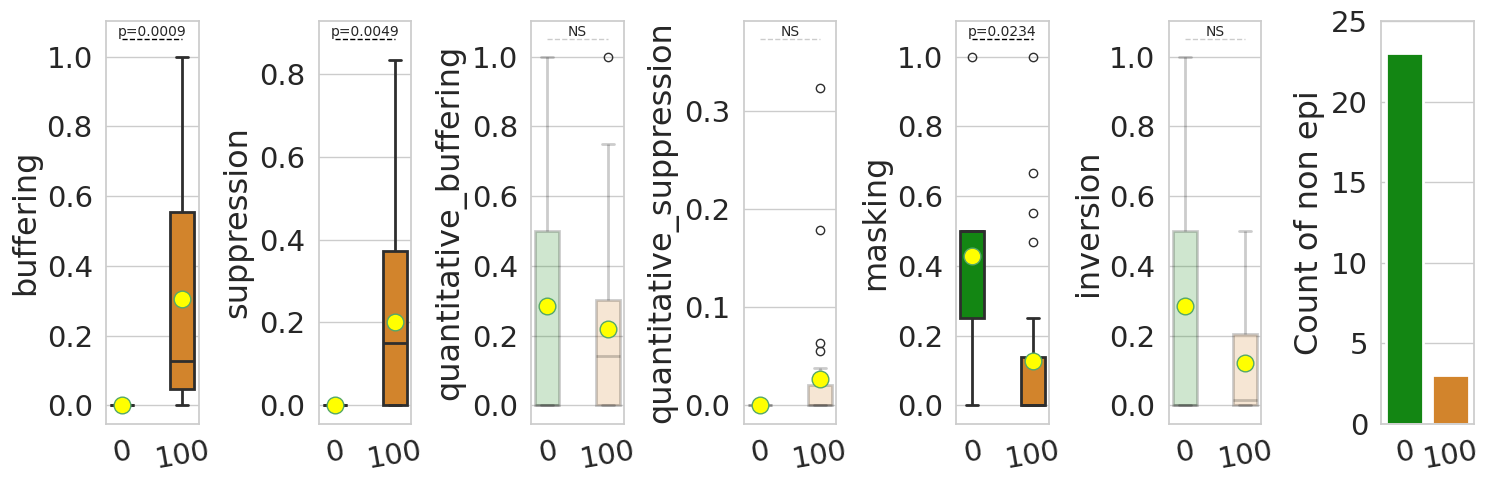

>> reg2m2


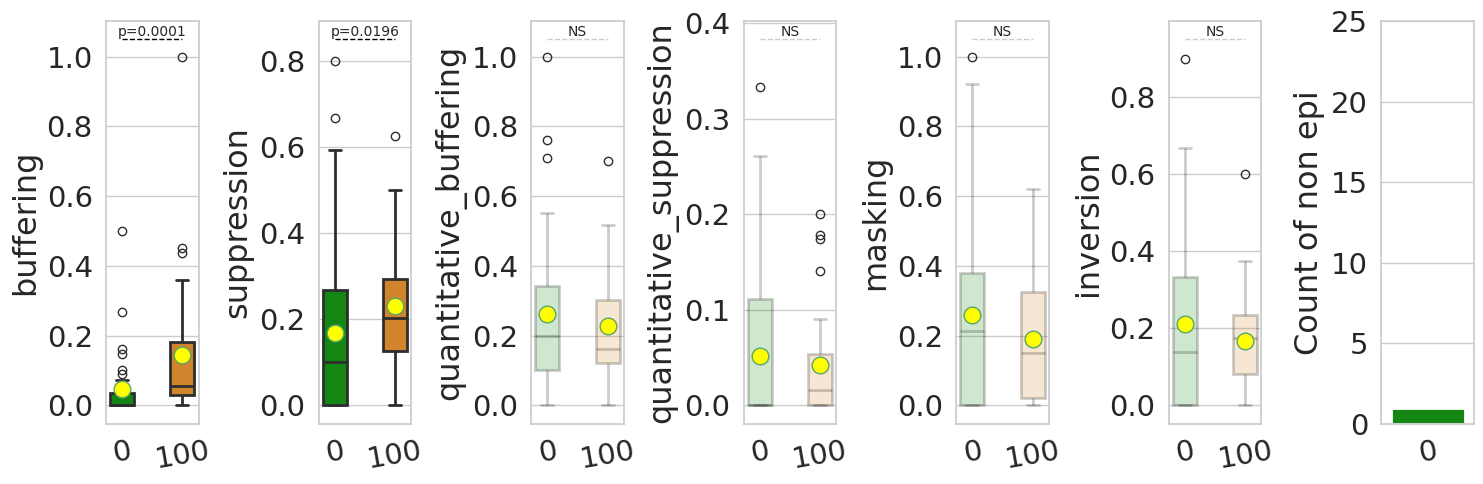

>>>>> head_balance
>> reg10m2


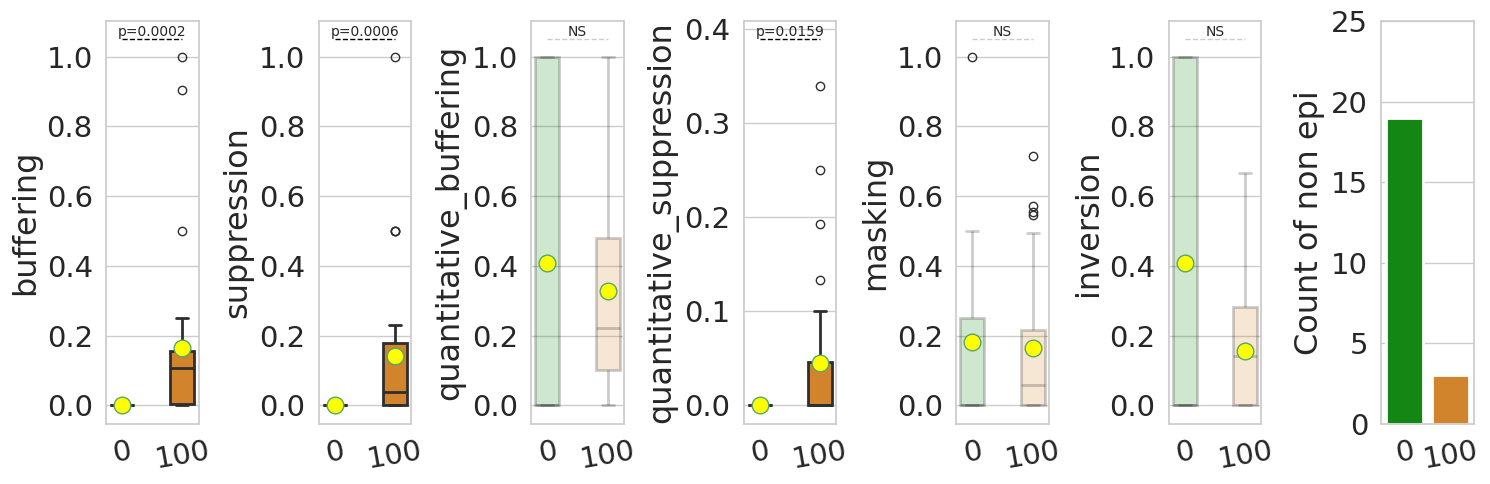

>> reg2m2


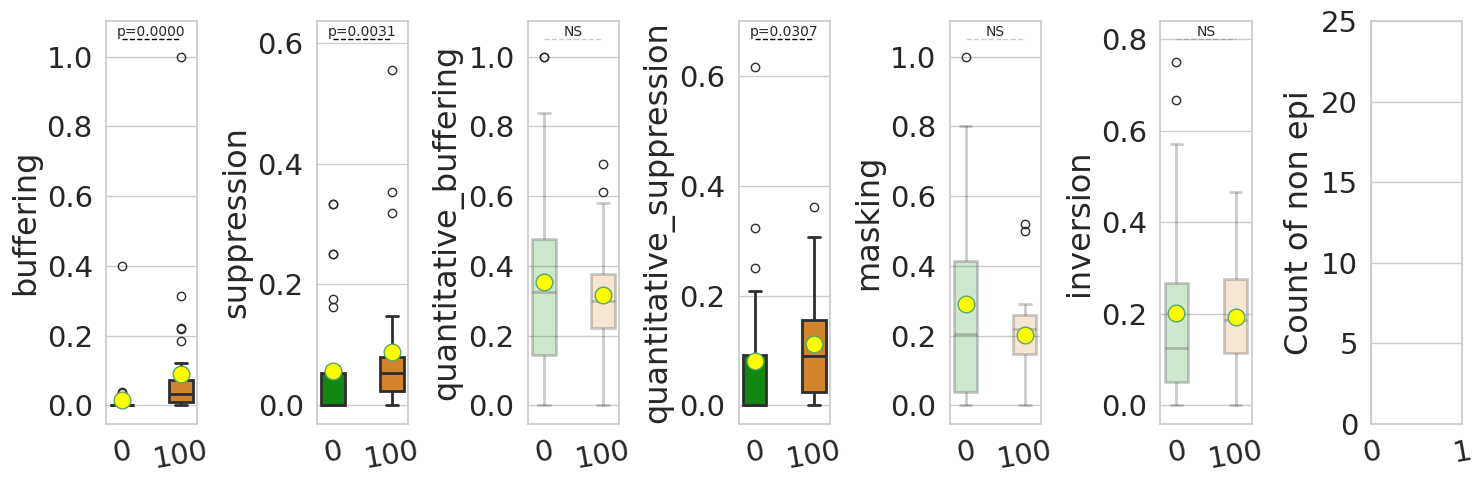

In [222]:
### EPISTASIS CATEG CHANGES ###
 
metrics = ['buffering', 'suppression', 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion']

clrs = ['#009900',

        
        '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4],'extremities_prop': [-0.05, 1.1],'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
sb.set_style("whitegrid")

for trait in traits:
    print('>>>>>',trait)
    df_trait = df_categ_traits[trait].copy(deep=True)
    
    for exp in experiments:
        print('>>',exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
        df_trait_exp = df_trait_exp[ (df_trait_exp['ranking'] == 'best') ] 
   
        df_trait_exp_zero = df_trait_exp[ (df_trait_exp['epistasis'] == 0) ] 
        df_trait_exp = df_trait_exp[ (df_trait_exp['epistasis'] > 0) ] 
       
        df_trait_exp[metrics] = df_trait_exp[metrics].fillna(0)
        
        fig, axes = plt.subplots(1, 7, figsize=(15, 5))  #
       
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
            #print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")

            sb.boxplot(x='gen', y=f'{metric}', data=filtered_clean,
                       palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                       meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)
    
            y_max = filtered_clean[f'{metric}'].max() + 0.05             
            x_positions = [0, 1]  
            ax.plot(x_positions, [y_max, y_max], color='black', linestyle='--', linewidth=1)
            if p_value >= 0.05:
                sig = 'NS'
                alpha = 0.2
                for patch in ax.patches:
                    patch.set_alpha(alpha)
                    patch.set_edgecolor((0.0, 0.0, 0.0, alpha))  # Example RGBA border color
                for line in ax.lines:
                    if line.get_linestyle() == '-' or line.get_linestyle() == '--':
                        line.set_color((0.0, 0.0, 0.0, alpha))  
                 
            else:
                sig = f'p={p_value:.4f}'
            ax.text(x=0.5, y=y_max, s=sig, ha='center', va='bottom', fontsize=10)
      
            ax.tick_params(axis='x', labelrotation=10)
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')


        ax = axes[idx+1]

        # Create a bar plot to count the number of rows for each 'gen'
        sb.countplot(x='gen', data=df_trait_exp_zero, palette=clrs, linewidth=2, ax=ax)
        
        # Customize the plot
        ax.tick_params(axis='x', labelrotation=10)
        ax.set_xlabel('')
        ax.set_ylabel(f'Count of non epi')
        ax.set_ylim(0, 25) 
        
        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.show()
    


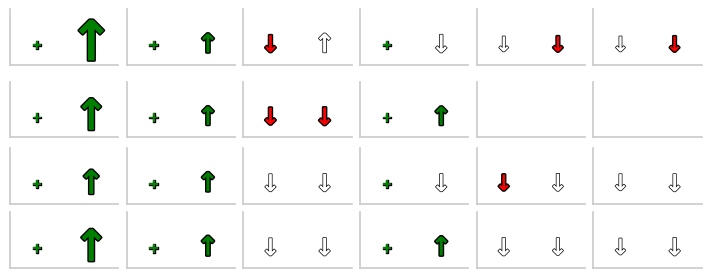

In [233]:
# Create a figure for the grid
fig, ax = plt.subplots(len(traits), len(metrics), figsize=(7, 2.7), constrained_layout=True)

for i, trait in enumerate(traits):
    df_trait = df_categ_traits[trait].copy(deep=True)
    for j, metric in enumerate(metrics):
        for k, exp in enumerate(experiments):
            df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
            df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            # Calculate the averages
            avg_ini_gen = ini_gen.mean()
            avg_end_gen = end_gen.mean()

            # Perform the Mann-Whitney U test
            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
         
            # Calculate the ratio of gen 100 to gen 0
            ratio = (avg_end_gen / avg_ini_gen) * 100
            #print(trait, metric, exp, avg_ini_gen, avg_ini_gen,ratio , p_value)

            min_old, max_old = 6, 878
            min_new, max_new = 15, 40
            
            # Normalize the variable from [6, 2000] to [10, 60]
            arrow_zize = ((ratio- min_old) / (max_old - min_old)) * (max_new - min_new) + min_new

            # Determine the subcell width and x-position for horizontal stacking
            subcell_width = 1.0 / len(experiments)
            x_position = k * subcell_width

            if (ratio == np.inf or ratio == -np.inf)  :# and not(np.isnan(ratio)):
                ax[i, j].annotate('+', xy=(x_position + subcell_width / 2, 0.35), xytext=(x_position + subcell_width / 2, 0.35),
                  textcoords='axes fraction', alpha=alpha, ha='center', va='center', color='green', fontsize=10, fontweight='bold',
                  path_effects=[path_effects.withStroke(linewidth=1, foreground='black')])
                
            if p_value >= 0.05:
                alpha = 1
                border = 1
            else:
                alpha = 1
                border = 2

            display_text = f'{ratio:.0f}%'
            
            if ratio > 100:
                if p_value >= 0.05:
                    a_color = 'white'
                else:
                    a_color = 'green'
                    
                # Green arrow pointing up, below the text
              #  ax[i, j].text(x_position + subcell_width / 2, 0.65, display_text, ha='center', va='center', fontsize=12, color='black')
                ax[i, j].annotate('↑', xy=(x_position + subcell_width / 2, 0.35), xytext=(x_position + subcell_width / 2, 0.35),
                                  textcoords='axes fraction', alpha=alpha, ha='center', va='center', color=a_color, fontsize=arrow_zize, fontweight='bold',
                                  path_effects=[path_effects.withStroke(linewidth=border, foreground='black')])
            else:
                if p_value >= 0.05:
                    a_color = 'white'
                else:
                    a_color = 'red'
                # Red arrow pointing down, above the text
              #  ax[i, j].text(x_position + subcell_width / 2, 0.35, display_text, ha='center', va='center', fontsize=12, color='black')
                ax[i, j].annotate('↓', xy=(x_position + subcell_width / 2, 0.35), xytext=(x_position + subcell_width / 2, 0.35),
                                  textcoords='axes fraction',  alpha=alpha, ha='center', va='center', color=a_color, fontsize=arrow_zize, fontweight='bold',
                                  path_effects=[path_effects.withStroke(linewidth=border, foreground='black')])

            # Draw the borders for each metric cell and subcells
            ax[i, j].spines['top'].set_visible(False)
            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['bottom'].set_visible(True)
            ax[i, j].spines['left'].set_visible(True)        

            # Draw the borders for the subcells
            ax[i, j].add_patch(plt.Rectangle((x_position, 0), subcell_width, 1, fill=False, edgecolor='white', lw=0.5))

        # Set the grid borders
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

# Set row labels for traits
# for i, trait in enumerate(traits):
#     ax[i, 0].set_ylabel(trait, fontsize=8, rotation=90, labelpad=30, ha='right')

plt.show()
fig.savefig(f'{path}/knockouts/epistasis_categ_change.png', dpi=300, bbox_inches='tight')


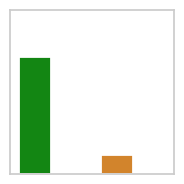

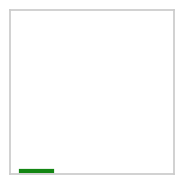

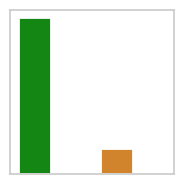

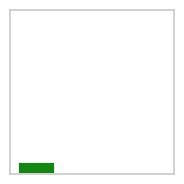

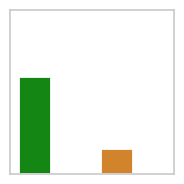

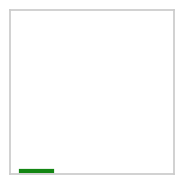

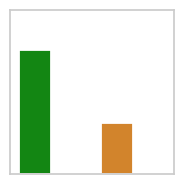

In [95]:

metrics = ['buffering', 'suppression', 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion']

clrs = ['#009900', '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4], 'extremities_prop': [-0.05, 1.1], 'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}


sb.set_style("whitegrid")

for trait in traits:
    #print('>>>>>', trait)
    df_trait = df_categ_traits[trait].copy(deep=True)
    
    for exp in experiments:
        #print('>>', exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
        df_trait_exp = df_trait_exp[df_trait_exp['ranking'] == 'best']
        
        df_trait_exp_zero = df_trait_exp[df_trait_exp['epistasis'] == 0]
        
        # Count the number of rows in df_trait_exp_zero
        num_rows = df_trait_exp_zero.shape[0]
        #print(f'The number of rows in df_trait_exp_zero is: {num_rows}')
        
        if num_rows > 0:
            fig, ax = plt.subplots(1, 1, figsize=(2, 2))

            # Create countplot
            sb.countplot(x='gen', data=df_trait_exp_zero, palette=clrs, linewidth=2, ax=ax)
            
            # Remove x-axis labels
            ax.set_xticklabels([''] * len(ax.get_xticks()))

            # Consistent bar width
            for patch in ax.patches:
                patch.set_width(0.4)  # Adjust width to keep it consistent

            # Add a dummy bar if there's only one bar
            if len(ax.patches) == 1:
                ax.bar(1, 0, width=0.4, color='white', edgecolor='white')  # Invisible bar to maintain spacing

            # Remove y-axis labels
            ax.set_yticklabels([])
            ax.set_xlabel('')
            ax.set_ylabel('')

            # Set y-axis limit
            ax.set_ylim(0, 25)
            
            # Adjust the layout and display the plot
            plt.tight_layout()
            ax.grid(False)
            plt.show()
            
            fig.savefig(f'{path}/knockouts/epistasis_nochange_{trait}_{exp}.png', dpi=300, bbox_inches='tight')

>> reg10m2


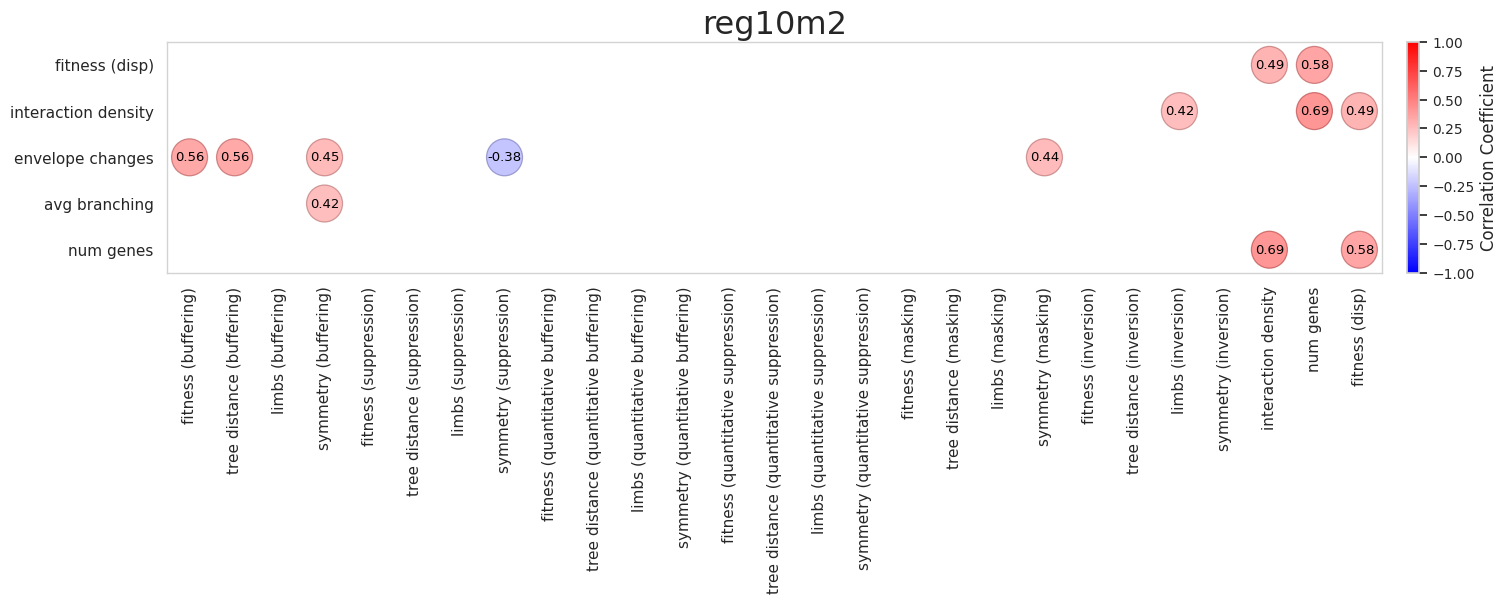

>> reg2m2


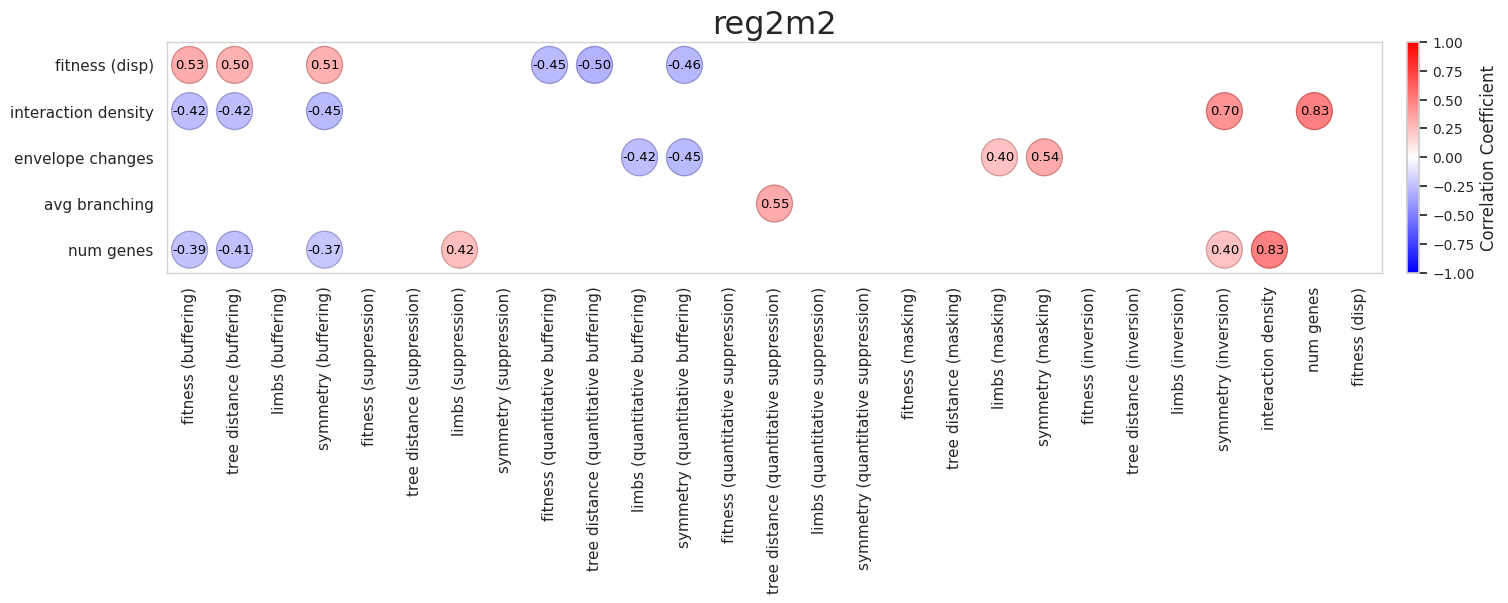

In [96]:
### CORRELATIONS: CATEG EPISTASIS VS PHENOCOMPLEXITY

metrics1 = ['n_genes', 'complexity_branch', 'complexity_env', 'interactions_density', 'disp_y']
additional_columns = ['interactions_density', 'n_genes', 'disp_y'] 
metrics2 = []

metrics1_adjusted = ['num genes', 'avg branching', 'envelope changes', 'interaction density', 'fitness (disp)']
metrics2_adjusted = ['fitness (buffering)', 'tree distance (buffering)', 'limbs (buffering)', 'symmetry (buffering)', 
                     'fitness (suppression)', 'tree distance (suppression)', 'limbs (suppression)', 'symmetry (suppression)', 
                     'fitness (quantitative buffering)', 'tree distance (quantitative buffering)', 'limbs (quantitative buffering)',
                     'symmetry (quantitative buffering)', 'fitness (quantitative suppression)', 'tree distance (quantitative suppression)', 
                     'limbs (quantitative suppression)', 'symmetry (quantitative suppression)', 'fitness (masking)', 
                     'tree distance (masking)', 'limbs (masking)', 'symmetry (masking)',
                     'fitness (inversion)', 'tree distance (inversion)', 'limbs (inversion)', 'symmetry (inversion)']
additional_columns_adjusted = ['interaction density', 'num genes', 'fitness (disp)']

categs = ['buffering', 'suppression' , 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion'] 

for idx,trait in enumerate(traits):
    df_trait = df_categ_traits[trait].copy(deep=True) 
    df_trait = df_trait.drop(columns=['Unnamed: 0'])

    corr_df = pd.merge(df_complexity_end, df_trait, on=keys, how='inner')

    for categ in categs:
        corr_df = corr_df.rename(columns={categ: f'{categ}_'+trait    })
        
    obsolete_vars = ['symmetry', 'extremities_prop' , 'epistasis']
    redudant_vars = [ 'ranking', 'disp_y', 'geno_size', 'n_genes', 'complexity_env',
                     'complexity_branch', 'complexity_net', 'interactions_density']

    if idx == 0:
        corr_df_all = corr_df.drop(columns=obsolete_vars)
    else:
        corr_df = corr_df.drop(columns=obsolete_vars+redudant_vars)
        corr_df_all = pd.merge(corr_df_all, corr_df, on=keys, how='inner')

metrics2 = []
for categ in categs:
  for idx,trait in enumerate(traits):
      metrics2.append(f'{categ}_' + trait )

for idx_experiment, exp in enumerate(experiments):
    print('>>', exp)
    df_complexity_end_exp = corr_df_all[(corr_df_all['experiment_name'] == exp)]
    df_complexity_end_exp = df_complexity_end_exp[ (df_complexity_end_exp['ranking'] == 'best') ] 
    df_complexity_end_exp[df_complexity_end_exp.select_dtypes(include=['number']).columns] = df_complexity_end_exp.select_dtypes(include=['number']).fillna(0)

    def darken_color(color, factor=0.7):
        r, g, b, a = mcolors.to_rgba(color)
        return mcolors.to_hex((r * factor, g * factor, b * factor, a))
    
    # Function to calculate correlation and p-values
    def calculate_corr_and_pvalues(df):
        corr_matrix = df.corr()
        p_values = pd.DataFrame(np.zeros_like(corr_matrix, dtype=float), index=corr_matrix.index, columns=corr_matrix.columns)
        
        for i in range(len(corr_matrix.columns)):
            for j in range(len(corr_matrix.columns)):
                if i != j:
                    corr, p_value = stats.pearsonr(df.iloc[:, i], df.iloc[:, j])
                    p_values.iloc[i, j] = p_value
                    if p_value < 0.05:
                        pass
                       # print(corr_matrix.columns[i], corr_matrix.columns[j], corr, p_value)
                else:
                    p_values.iloc[i, j] = np.nan  # No p-value for self-correlation
    
        return corr_matrix, p_values
    
    
    # Compute correlations and p-values
    corr_matrix, p_values = calculate_corr_and_pvalues(df_complexity_end_exp[metrics1 + metrics2])
    
    original_names = metrics1 + metrics2 + additional_columns
    adjusted_names = metrics1_adjusted + metrics2_adjusted + additional_columns_adjusted
    rename_mapping = {original: adjusted for original, adjusted in zip(original_names, adjusted_names)}
    corr_matrix = corr_matrix.rename(columns=rename_mapping, index=rename_mapping)
    p_values = p_values.rename(columns=rename_mapping, index=rename_mapping)
    

    
    # Select the relevant portion of the correlation matrix
    corr_matrix = corr_matrix.loc[metrics1_adjusted, metrics2_adjusted + additional_columns_adjusted]
    p_values = p_values.loc[metrics1_adjusted, metrics2_adjusted + additional_columns_adjusted]
    
    # Create a mask for significant correlations
    significance_mask = p_values < 0.05
    
    # Create a color map from blue to red
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'blue_red',
        ['blue', 'white', 'red'],
        N=256
    )
    
    # Plotting
    plt.figure(figsize=(16.5, 3))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('#D3D3D3')   # Set the color for all spines
        spine.set_linewidth(1) 
    
    # Draw the circles for significant correlations
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            if significance_mask.iloc[i, j]:
                circle_color = cmap((corr_matrix.iloc[i, j] + 1) / 2)  # Normalize correlation to [0, 1]
                border_color = darken_color(circle_color, factor=0.7)  # Darken the fill color for border
            
                circle = plt.Circle((j, i), 0.4, color=circle_color, alpha=0.6, ec=border_color, linewidth=0.9, zorder=10)
                ax.add_patch(circle)
                plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', color='black', 
                         ha='center', va='center', fontsize=9.5, zorder=20)
    
    # Set the labels and limits
    plt.xticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=90, fontsize=11)
    plt.yticks(ticks=np.arange(len(corr_matrix.index)), labels=corr_matrix.index, fontsize=11)
    plt.xlim(-0.5, len(corr_matrix.columns) - 0.5)
    plt.ylim(len(corr_matrix.index) - 0.5, -0.5)
    plt.title(exp)
    plt.grid(False)
    plt.gca().invert_yaxis()

    # Create and add color bar
    norm = mcolors.Normalize(vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label('Correlation Coefficient', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    plt.savefig(f'{path}/knockouts/corr_categ_{exp}.png', dpi=300, bbox_inches='tight')
    plt.show()



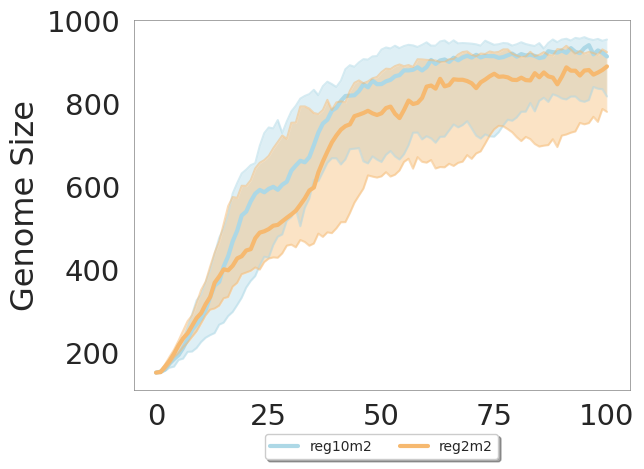

geno_size : 913.64 889.675 0.12597019317097233


<Figure size 640x480 with 0 Axes>

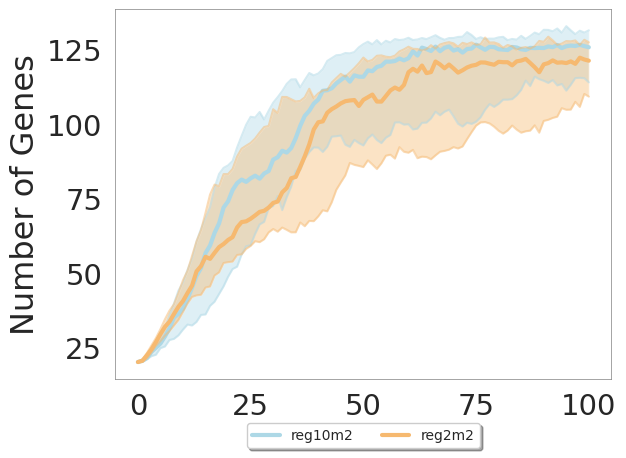

n_genes : 125.78 121.285 0.24882780948800975


<Figure size 640x480 with 0 Axes>

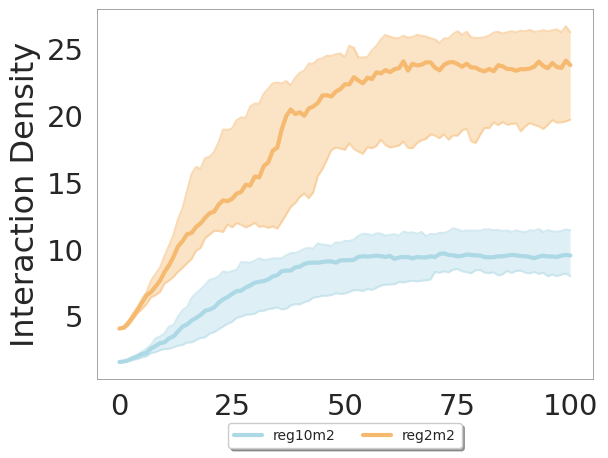

interactions_density : 9.511228235576208 23.73069998923436 1.173735436185757e-09


<Figure size 640x480 with 0 Axes>

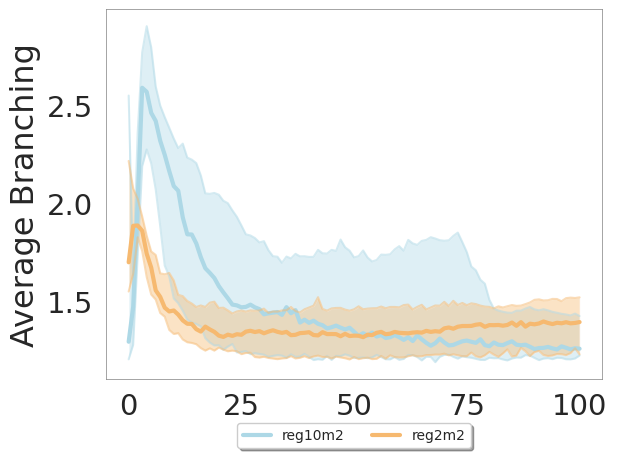

complexity_branch : 1.260595779220778 1.396315175021057 0.49638573117266804


<Figure size 640x480 with 0 Axes>

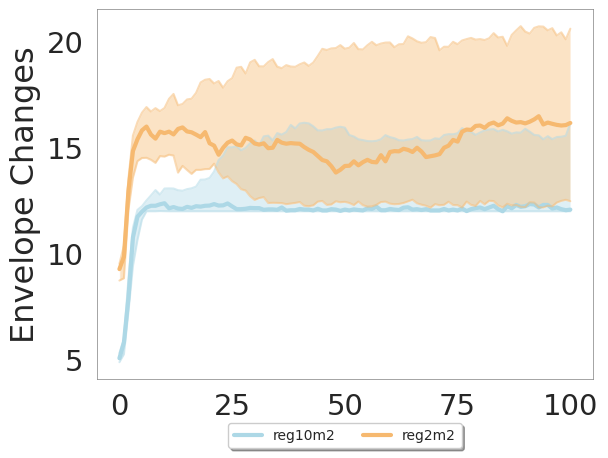

complexity_env : 12.08 16.17 0.025133128401547616


<Figure size 640x480 with 0 Axes>

In [118]:

### COMPLEXITY AND GENO SIZE PROGRESSION


grouped = df_complexity_all.groupby(['experiment_name', 'run', 'gen'])
df_complexity_inner = grouped.agg({
    'geno_size': 'mean',
    'complexity_branch': 'mean',
    'complexity_env': 'mean',
    'n_genes': 'mean',
    'interactions_density': 'mean'
})
df_complexity_inner = df_complexity_inner.reset_index()

q1 = lambda x: x.quantile(0.25)
q3 = lambda x: x.quantile(0.75)

grouped = df_complexity_inner.groupby(['experiment_name', 'gen'])
df_complexity_outer = grouped.agg({
    'geno_size': ['median', q1, q3],
    'complexity_branch': ['median', q1, q3],
    'complexity_env': ['median', q1, q3],
    'n_genes': ['median', q1, q3],
    'interactions_density': ['median', q1, q3]
})
df_complexity_outer.columns = [
    ('geno_size', 'median'), ('geno_size', 'Q1'), ('geno_size', 'Q3'),
    ('complexity_branch', 'median'), ('complexity_branch', 'Q1'), ('complexity_branch', 'Q3'),
    ('complexity_env', 'median'), ('complexity_env', 'Q1'), ('complexity_env', 'Q3'),
    ('n_genes', 'median'), ('n_genes', 'Q1'), ('n_genes', 'Q3'),
    ('interactions_density', 'median'), ('interactions_density', 'Q1'), ('interactions_density', 'Q3')
]
df_complexity_outer.columns = ['_'.join(col) for col in df_complexity_outer.columns]
df_complexity_outer = df_complexity_outer.reset_index()

clrs = ['#ADD8E6',
        '#F6B970']
traits_labels = ['Genome Size', 'Number of Genes', 'Interaction Density', 'Average Branching', 'Envelope Changes']

metrics = ['geno_size', 'n_genes', 'interactions_density', 'complexity_branch', 'complexity_env']
for idm, metric in enumerate(metrics):

    font = {'font.size': 20}
    plt.rcParams.update(font)
    fig, ax = plt.subplots()#figsize=(3,2))

    plt.xlabel('')
    plt.ylabel(f'{traits_labels[idm]}')
    ax.grid(False)
    ax.spines['top'].set_color('grey')
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_color('grey')
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_color('grey')
    ax.spines['left'].set_linewidth(0.5)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)


    for idx_experiment, exp in enumerate(experiments):
        metric_exp = df_complexity_outer[df_complexity_outer['experiment_name'] == exp]
        
        ax.plot(metric_exp['gen'], metric_exp[f'{metric}_median'],
                    label=f'{exp}', c=clrs[idx_experiment], linewidth=3)
        
        ax.fill_between(metric_exp['gen'],
                        metric_exp[f'{metric}_Q1'],
                        metric_exp[f'{metric}_Q3'],
                        alpha=0.4, facecolor=clrs[idx_experiment])
        
        ax.plot(metric_exp['gen'],
        metric_exp[f'{metric}_Q1'],
        linestyle='-', color=clrs[idx_experiment], alpha=0.5, linewidth=1.5)  # Contour line for Q1

        ax.plot(metric_exp['gen'],
        metric_exp[f'{metric}_Q3'],
        linestyle='-', color=clrs[idx_experiment], alpha=0.5, linewidth=1.5)  # Contour line for Q3

        
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  fancybox=True, shadow=True, ncol=5, fontsize=10)

    plt.show()
    plt.clf()
    fig.savefig(f'{path}/knockouts/{metric}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

    group1_data = df_complexity_inner[(df_complexity_inner['experiment_name'] == 'reg10m2') & (df_complexity_inner['gen'] == 100) ][f'{metric}']
    group2_data = df_complexity_inner[(df_complexity_inner['experiment_name'] == 'reg2m2') & (df_complexity_inner['gen'] == 100) ][f'{metric}']
    _, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
    print(metric, ':', group1_data.median(), group2_data.median(), p_value)




 >>>>> disp_y

 -- reg10m2
Average of 'b' in the first : 1.2517921540305315
Average of 'b' in the second : 1.8696160504827266
  p-value: 0.0043


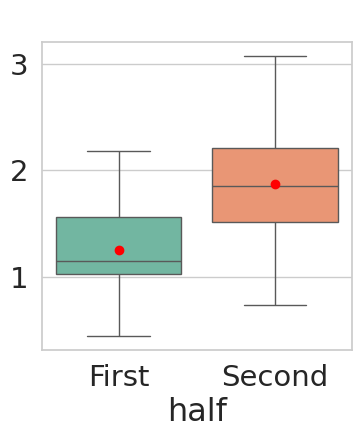


 -- reg2m2
Average of 'b' in the first : 2.1201436329943424
Average of 'b' in the second : 2.162267770400892
  p-value: 0.8098


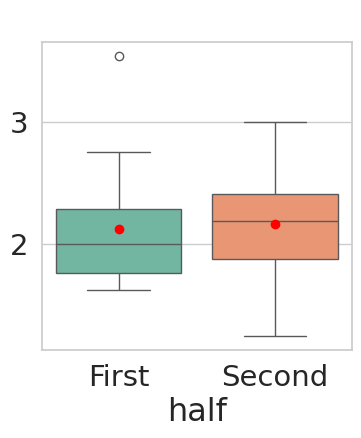

In [132]:

### FIT VS GRNOSIZE 


metrics_dist = [ 'disp_y']
metric_order = 'n_genes'

for metric_dist in metrics_dist:
    print('\n >>>>>',metric_dist)
    for exp in experiments:
        print('\n --',exp)
        df_comp_g = corr_df_all[ (corr_df_all['experiment_name'] == exp) ] 
        df_comp_g = df_comp_g[ (df_comp_g['ranking'] == 'best') ] 
        df_sorted = df_comp_g.sort_values(by=metric_order).reset_index(drop=True)
               
        # first_half = df_comp_g[ (df_comp_g[metric_order] <20) ] 
        # second_half = df_comp_g[ (df_comp_g[metric_order] >= 20) ] 

        midpoint = len(df_sorted) // 2
        first_half = df_sorted.iloc[:midpoint]
        second_half = df_sorted.iloc[midpoint:]
        
        # Calculate and display the averages for 'b' in each half
        avg_first_half = first_half[metric_dist].mean()
        avg_second_half = second_half[metric_dist].mean()
        #display(first_half)
      #  display(second_half)
        print(f"Average of 'b' in the first : {avg_first_half}")
        print(f"Average of 'b' in the second : {avg_second_half}")
        
        t_stat, p_value = ttest_ind(first_half[metric_dist], second_half[metric_dist], equal_var=True)
       # _, p_value = wilcoxon(first_half[metric_dist], second_half[metric_dist])
        #_, p_value = mannwhitneyu(first_half[metric_dist], second_half[metric_dist], alternative='two-sided')
        print(f"  p-value: {round(p_value, 4)}")
        
        # Add a new column to each half to indicate "First Half" or "Second Half"
        first_half['half'] = 'First'
        second_half['half'] = 'Second'
        
        #  Concatenate the two halves back into a single DataFrame
        df_concat = pd.concat([first_half, second_half], ignore_index=True)
        
        # Plot variable 'disp_y' for each half using box plots
        plt.figure(figsize=(4, 4))
        sb.boxplot(x='half', y=metric_dist, data=df_concat, palette="Set2")
        
        plt.scatter(x=[0], y=[avg_first_half], color='red', label='Mean', zorder=5)
        plt.scatter(x=[1], y=[avg_second_half], color='red', zorder=5)
        
        plt.title(' ')
        plt.ylabel('' )
        plt.show() 
